conda install -c conda-forge feature_engine**Primeramente vamos a realizar la instalación e importación de las librerias necesarias para el desarrollo de la práctica**

In [1]:
conda install -c conda-forge feature_engine

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [330]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


from feature_engine.encoding import MeanEncoder

import warnings
warnings.filterwarnings('ignore')




**Realizamos la lectura del csv que vamos a analizar y lo guardamos en una variable(full_df). Como el análisis lo vamos a realizar sobre las viviendas de Madrid, antes de realizar 
la división en train y test filtramos para obtener unicamente las viviendas de interés**

In [156]:
full_df = pd.read_csv('dataframes/airbnb-listings-extract.csv', sep=';', decimal='.')

**En las siguientes celdas vamos a realizar el filtrado del dataframe inicial para obtener unicamente alojamientos que estén ubicados en Madrid y la posterior división del dataframe en train y test para su guardado en formato csv**

In [157]:
print('Comprobamos cuantas ciudades hay en el dataframe \n')
pd.options.display.max_rows=30
print(full_df['City'].value_counts())
#Vamos a filtrar la columna city obteniendo las filas que contengan la palabra madrid
full_df['City'] = full_df['City'].fillna('')
full_df_madrid = full_df[full_df.City.str.contains('madrid', case=False)]
print('-----------------------------------------------\n')
print(f'Tras el filtrado realizado teniendo en cuenta unicamente la ciudad de Madrid hemos eliminado el {round(((full_df.shape[0]-full_df_madrid.shape[0])/full_df.shape[0])*100,2)}% de las filas.')

Comprobamos cuantas ciudades hay en el dataframe 

Madrid            13207
Barcelona           292
London              132
Paris               108
马德里                  52
                  ...  
Son Moll              1
La Habana             1
Mile End / Bow        1
Sint-Gillis           1
Son Vida              1
Name: City, Length: 246, dtype: int64
-----------------------------------------------

Tras el filtrado realizado teniendo en cuenta unicamente la ciudad de Madrid hemos eliminado el 10.39% de las filas.


In [158]:
train, test = train_test_split(full_df_madrid, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('dataframes/train.csv', sep=';', decimal='.', index=False)
test.to_csv('dataframes/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (10596, 89)
Dimensiones del dataset de test: (2649, 89)


**Antes de empezar a realizar el análisis exploratorio vamos a crear unas funciones que nos ayudaran en el análisis**

**Funciones para graficar**

La siguiente función genera gráficas de como se distribuye la variable en su forma original, cuadrática y logarítmica

In [159]:
def price_distribution(df):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
    sns.distplot(
        df.Price,
        hist    = False,
        rug     = True,
        color   = "blue",
        kde_kws = {'shade': True, 'linewidth': 1},
        ax      = axes[0]
    )
    axes[0].set_title("Distribución original", fontsize = 'medium')
    axes[0].set_xlabel('Price', fontsize='small') 
    axes[0].tick_params(labelsize = 6)

    sns.distplot(
        np.sqrt(df.Price),
        hist    = False,
        rug     = True,
        color   = "blue",
        kde_kws = {'shade': True, 'linewidth': 1},
        ax      = axes[1]
    )
    axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
    axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
    axes[1].tick_params(labelsize = 6)

    sns.distplot(
        np.log(df.Price),
        hist    = False,
        rug     = True,
        color   = "blue",
        kde_kws = {'shade': True, 'linewidth': 1},
        ax      = axes[2]
    )
    axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
    axes[2].set_xlabel('log(precio)', fontsize='small') 
    axes[2].tick_params(labelsize = 6)

    fig.tight_layout()

La siguiente es una función a la que pasandolo por argumento el df y las columnas a graficar te genera los histogramas:

In [160]:
def create_hist(df, columns=None):
    """ Función que crea los histogramas en subplots. la función calcula el numero de filas a generar y extrae las columnas numéricas del dataframe por defecto
        Si solo se quiere graficar ciertas dimensiones se puede pasar por parametro en forma de lista:
        df= df de pandas
        columns=None graficará todo el df, se puede pasar lista con dim a graficar"""   
    num_columns= df[columns].colums if columns else df.select_dtypes(include=['float64', 'int64']).columns.drop('Price')
    size= math.ceil(len(num_columns)/3)
    fig, axes = plt.subplots(nrows=size, ncols=3, figsize=(18, 5*size))
    axes = axes.flat
    fig.suptitle('Distribución variables numéricas',va='top', y= 1,fontsize = 18)
    for i, col in enumerate(num_columns):
        sns.histplot(
            data    = df,
            x       = col,
            stat    = "count",
            kde     = True,
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
            line_kws= {'linewidth': 2},
            alpha   = 0.3,
            ax      = axes[i]
        )
        axes[i].set_title(col, fontsize = 12)
        axes[i].tick_params(labelsize = 10)
        plt.subplots_adjust(top=0.9)
        axes[i].set_xlabel("")
        fig.tight_layout()
     #Borramos los subplots que queden vacios
    graf_del = size*3 - len(num_columns)
    if graf_del == 1 :
        fig.delaxes(axes[-1])
    if graf_del == 2 :
        fig.delaxes(axes[-1])
        fig.delaxes(axes[-2])  

In [161]:
def create_scatter(df, columns=None, y = 'Price'):
    """ Función que crea los scatter en subplots. la función calcula el numero de filas a generar y extrae las columnas numéricas del dataframe por defecto
        Por defecto te realizará la comparación con la variable Price, si se desea compara con otra variable se le puede pasar por parámetro como y
        Si solo se quiere graficar ciertas dimensiones se puede pasar por parametro en forma de lista:
        df= df de pandas
        columns=None graficará todo el df, se puede pasar lista con dim a graficar
        y = 'Price' Valor por defecto de la columna buscada"""
    num_columns = df[columns].columns if columns else df.select_dtypes(include=['float64', 'int64']).columns.drop(y)
    size= math.ceil(len(num_columns)/3)
    fig, axes = plt.subplots(nrows=size, ncols=3, figsize=(16, 5*size))
    axes = axes.flat
    fig.suptitle('Relación entre variables',va='top', y= 1,fontsize = 18)
    for i, colum in enumerate(num_columns):
        sns.regplot(
            x           = df[colum],
            y           = df[y],
            color       = "gray",
            marker      = '.',
            scatter_kws = {"alpha":0.4},
            line_kws    = {"color":"r","alpha":0.5},
            ax          = axes[i]
        )
        axes[i].set_title(f"{y} vs {colum}", fontsize = 12)
        axes[i].tick_params(labelsize = 10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
    fig.tight_layout()
    #Borramos los subplots que queden vacios
    graf_del = size*3 - len(num_columns)
    if graf_del == 1 :
        fig.delaxes(axes[-1])
    if graf_del == 2 :
        fig.delaxes(axes[-1])
        fig.delaxes(axes[-2])       


La siguiente función nos genera los gráficos boxplot

In [162]:
def create_boxplot(df, columns = None):
    """Funcion que genera por defecto dibuja graficos boxplot de todos las dimensiones de df con tipo ['object', 'uint8'], si se le pasa una lista con 
    dimensiones del df unicamente graficará dicha lista:
        df = dataframe de pandas
        columns = None por defecto grafica todo el df, lista de dimensiones que quiers graficar
        """
    
    object_columns= df[columns].columns if columns else df.select_dtypes(include=['object', 'uint8']).columns
    #Para realizar una buena visualizacion de los dummies vamos a eliminar del conteo para las filas los dummies que representan los SI
    columns_to_drop = [col for col in object_columns if ("_NO") in col]  
    object_columns = object_columns.drop(columns_to_drop) if columns_to_drop else  object_columns
    size= math.ceil(len(object_columns)/2)
    fig, axes= plt.subplots(nrows=size, ncols=2, figsize=(16, 6*size))
    axes = axes.flat
    fig.suptitle('Distribución del precio por variable categórica',va='top', y= 1,fontsize = 18)
    for i, col in enumerate(object_columns):
        if df[col].dtypes == 'object':  
            sns.boxplot(data= df,
                        x           = 'Price',
                        y           = col,
                        width       = 0.7,
                        ax          = axes[i]
                )
            axes[i].set_title(f"{col}", fontsize = 12)
            axes[i].tick_params(labelsize = 10)
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")    
            
        if df[col].dtypes == 'uint8':            
            sns.boxplot(data= df,
                        x           = col,
                        y           = 'Price',
                        width       = 0.7,
                        ax          = axes[i]
                )
            axes[i].set_title(f"{col[:-3]} (NO=0 SI=1)", fontsize = 12)
            axes[i].tick_params(labelsize = 10)
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")               
    
    fig.tight_layout()
    #Borramos los subplots que queden vacios
    graf_del = size*2 - len(object_columns)
    if graf_del == 1 :
        fig.delaxes(axes[-1])


La siguiente funcion dibuja la distribución de las variables cuantitativas

In [163]:
def create_dist_categ(df, columns = None):
    object_columns= df[columns].columns if columns else df.select_dtypes(include=['object']).columns
    size= math.ceil(len(object_columns)/2)
    fig, axes= plt.subplots(nrows=size, ncols=2, figsize=(16, 6*size))
    axes = axes.flat
    columnas_object = df.select_dtypes(include=['object']).columns
    fig.suptitle('Distribución variables categóricas',fontsize = 18)
    for i, colum in enumerate(columnas_object):
        df[colum].value_counts().plot.barh(ax = axes[i])
        axes[i].set_title(colum, fontsize = 12)
        axes[i].tick_params(labelsize = 10)
        axes[i].set_xlabel("")

    # Se eliminan los axes vacíos
    graf_del = size*2 - len(object_columns)
    if graf_del == 1 :
        fig.delaxes(axes[-1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)   

In [164]:
def corr_matrix(df):
    """función que calcula la matriz de correlación de las dimensiones numéricas de un df
    df = dataframe de pandas"""
    num_colums = df.select_dtypes(include=['float64', 'int64'])
    corr = np.abs(num_colums.drop(['Price'], axis=1).corr())

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5, annot = True,
                linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
    f.suptitle('Matriz de correlación', fontsize=18)
    plt.show()


**Funciones para trasnformar DF**

La siguient función elimina columnas del dataframe

In [165]:
def first_trasnformation(df,colums_to_remove):
    """Función a la que le pasamos el df a tratar y una lista con los nombres de las columnas a borrar
        df = dataframe de pandas
        colums_to_remove = lista de las columnas a eliminar"""
    return df.drop(colums_to_remove,axis=1)

La siguiente función realiza varias modificaciones, por un lado modifica la dimensión Security Deposit, cambiandola a categórica (SI/NO), realizando la suposición de que los valores NA indican que no se requiere fianza. Por otro lado realiza una busqueda en la columna de Amenities para saber si el alojamiento tiene aire acondicionado y calefacción creando dos columnas en donde indica (SI/NO). y por último convierte a dummies las 3 columnas trasnformadas

In [166]:
def second_transformation(df):
    """Función que crea las dummies tras trasnformar a categóricas 3 dimensiones, la existencia de A/C, la existencia calfaccción en la vivienda y 
    si se cobra o no fianza. Por último elimina la columna Amenities
        df= dataframe de pandas"""
    
    df['Security Deposit'] = df['Security Deposit'].map(lambda x: 'SI' if x>0 else 'NO')
    condition_heat = df['Amenities'].str.contains('heating', case=False)
    condition_air = df['Amenities'].str.contains('Air conditioning', case=False)
    df['Heating'] = np.where(condition_heat, 'SI','NO')
    df['Air conditioning'] = np.where(condition_air, 'SI','NO')
    #Trasnforma las 3 columnas anteriores a dummies
    df = pd.get_dummies(df,prefix=['A/C','Heat','Sec_Dep'],columns=['Air conditioning','Heating','Security Deposit'])
    return df.drop('Amenities', axis=1)


La siguiente función reagrupa niveles de variables categóricas para eliminar una granulación excesiva 

In [167]:
def regroup_values(df,column,list_index, new_value = 'Other'):    
    """Esta función realiza una reagrupación de niveles de una columna de variable categórica:
        df = dataframe de pandas
        column = columna a modificar 
        list_index = lista de valores que se mantendrán, al resto que no se correspondan con la lista les pondrá el valor other por defecto
        new_value = 'Other' valor que añadirá por defecto"""
    df[column] = [new_value if x not in list_index else x for x in df[column]]

**Realizamos la carga del archivo csv y lo guardamos en una variable llamada df**

In [168]:
df = pd.read_csv('dataframes/train.csv', sep=';', decimal='.')

**En el siguiente paso vamos a realizar un análisis exploratorio del df de train con el que vamos a trabajar**

En primer lugar vamos a ver como se distribuye la variable buscada mediante gráficas de densidad de probabilidad

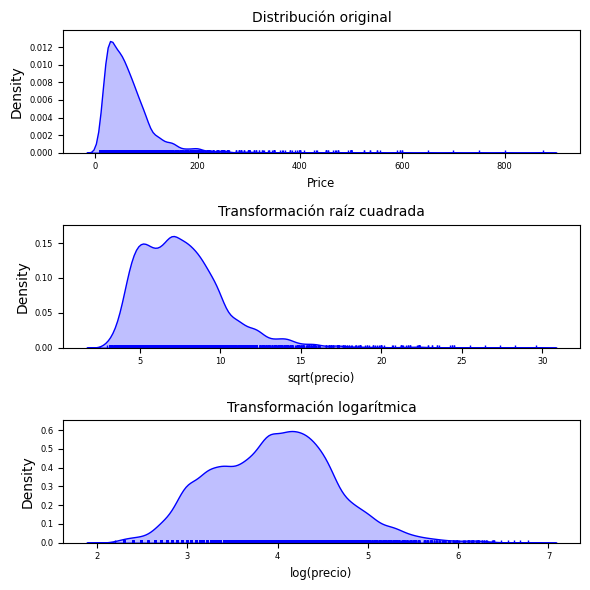

In [169]:
price_distribution(df)

In [170]:
pd.options.display.max_rows=None 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10596 non-null  int64  
 1   Listing Url                     10596 non-null  object 
 2   Scrape ID                       10596 non-null  int64  
 3   Last Scraped                    10596 non-null  object 
 4   Name                            10596 non-null  object 
 5   Summary                         10202 non-null  object 
 6   Space                           7731 non-null   object 
 7   Description                     10593 non-null  object 
 8   Experiences Offered             10596 non-null  object 
 9   Neighborhood Overview           6620 non-null   object 
 10  Notes                           4026 non-null   object 
 11  Transit                         6577 non-null   object 
 12  Access                          

In [78]:
pd.options.display.max_columns=None 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10596.0,1.040393e+07,5.520123e+06,1.862800e+04,5.786814e+06,1.152145e+07,1.537016e+07,1.810918e+07
Scrape ID,10596.0,2.017041e+13,4.343955e+00,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13
Host ID,10596.0,3.735013e+07,3.435663e+07,1.745300e+04,7.649063e+06,2.734185e+07,5.705880e+07,1.247534e+08
Host Response Rate,9278.0,9.483994e+01,1.524988e+01,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Host Acceptance Rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host Listings Count,10593.0,9.799113e+00,2.774508e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Host Total Listings Count,10593.0,9.799113e+00,2.774508e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Latitude,10596.0,4.042052e+01,2.015372e-02,4.033189e+01,4.041005e+01,4.041865e+01,4.042779e+01,4.056274e+01
Longitude,10596.0,-3.697153e+00,2.356882e-02,-3.863907e+00,-3.707707e+00,-3.701551e+00,-3.693819e+00,-3.573613e+00
Accommodates,10596.0,3.190260e+00,2.000907e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01


In [79]:
#Comprobamos los valores nulos de cada columna
pd.options.display.max_rows=None 
df.isnull().sum()

ID                                    0
Listing Url                           0
Scrape ID                             0
Last Scraped                          0
Name                                  0
Summary                             394
Space                              2865
Description                           3
Experiences Offered                   0
Neighborhood Overview              3976
Notes                              6570
Transit                            4019
Access                             4576
Interaction                        4617
House Rules                        3704
Thumbnail Url                      2009
Medium Url                         2009
Picture Url                          15
XL Picture Url                     2009
Host ID                               0
Host URL                              0
Host Name                             3
Host Since                            3
Host Location                        36
Host About                         4007


**Tras realizar una primera visualización del tipo de columnas que tiene el DF, se observa que existen muchas columnas que en principio no serían relevantes para el análisis que vamos a realizar o que unicamente contiene NA o tienen muy pocas filas con dicha información como puede ser el precio semanal o mensual o que contienen información redundante. En este punto podriamos valorar la posibilidad de categorizar alguna de las características que nos proporciona la columna Ammenities.**

**Vamos a eliminar las columnas que en base a lo anterior son irrelevantes:**

In [171]:
#Creamos una variable que almacene las columnas que queremos eliminar y realizamos la llamada a la función que elimina columnas para llevar a cabo 
#la primera transformación del DF de train
colums_to_remove = ['ID','Host ID','Listing Url','Scrape ID','Last Scraped','Neighbourhood Cleansed','Name','Summary','Space','Description','Experiences Offered','Neighborhood Overview','Notes','Transit',
                    'Access','Interaction','House Rules','Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Name','Host About', 'Host Response Rate',
                    'Calculated host listings count','Host Thumbnail Url','Host Picture Url','Host Verifications','Features','Square Feet','Host Acceptance Rate','Has Availability',
                    'Jurisdiction Names','Latitude','Longitude','Weekly Price','Monthly Price','Country','License','Geolocation','Calendar last Scraped','Calendar Updated','Square Feet',
                    'Host Neighbourhood','Host Response Time','Reviews per Month','First Review','Last Review','Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
                    'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value','Reviews per Month','Neighbourhood','Market','State','Zipcode',
                    'Smart Location','Country Code','Host Location','Host Listings Count','Host Total Listings Count','Host Since','City','Street','Guests Included','Number of Reviews']
df = first_trasnformation(df,colums_to_remove)

In [172]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Accommodates,10596.0,3.190260,2.000907,1.0,2.0,2.0,4.0,16.0
Bathrooms,10559.0,1.251776,0.602483,0.0,1.0,1.0,1.0,8.0
Bedrooms,10580.0,1.291210,0.822789,0.0,1.0,1.0,2.0,10.0
Beds,10558.0,1.991760,1.527565,1.0,1.0,2.0,2.0,16.0
Price,10588.0,66.068946,56.414585,9.0,30.0,52.0,80.0,875.0
Security Deposit,4479.0,183.243804,108.810750,70.0,100.0,150.0,200.0,990.0
Cleaning Fee,6241.0,29.492069,25.720340,4.0,15.0,25.0,35.0,500.0
Extra People,10596.0,7.413364,10.530548,0.0,0.0,0.0,14.0,274.0
Minimum Nights,10596.0,3.001038,13.300005,1.0,1.0,2.0,3.0,1125.0
Maximum Nights,10596.0,977.748773,9914.065304,1.0,365.0,1125.0,1125.0,1000000.0


In [163]:
df.isnull().sum()

Neighbourhood Group Cleansed       0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                         37
Bedrooms                          16
Beds                              38
Bed Type                           0
Amenities                         91
Price                              8
Security Deposit                6117
Cleaning Fee                    4355
Extra People                       0
Minimum Nights                     0
Maximum Nights                     0
Availability 30                    0
Availability 60                    0
Availability 90                    0
Availability 365                   0
Cancellation Policy                0
dtype: int64

**Análisis de variables numéricas:**

En la siguiente celda generamos los histogramas de las variables numérica.

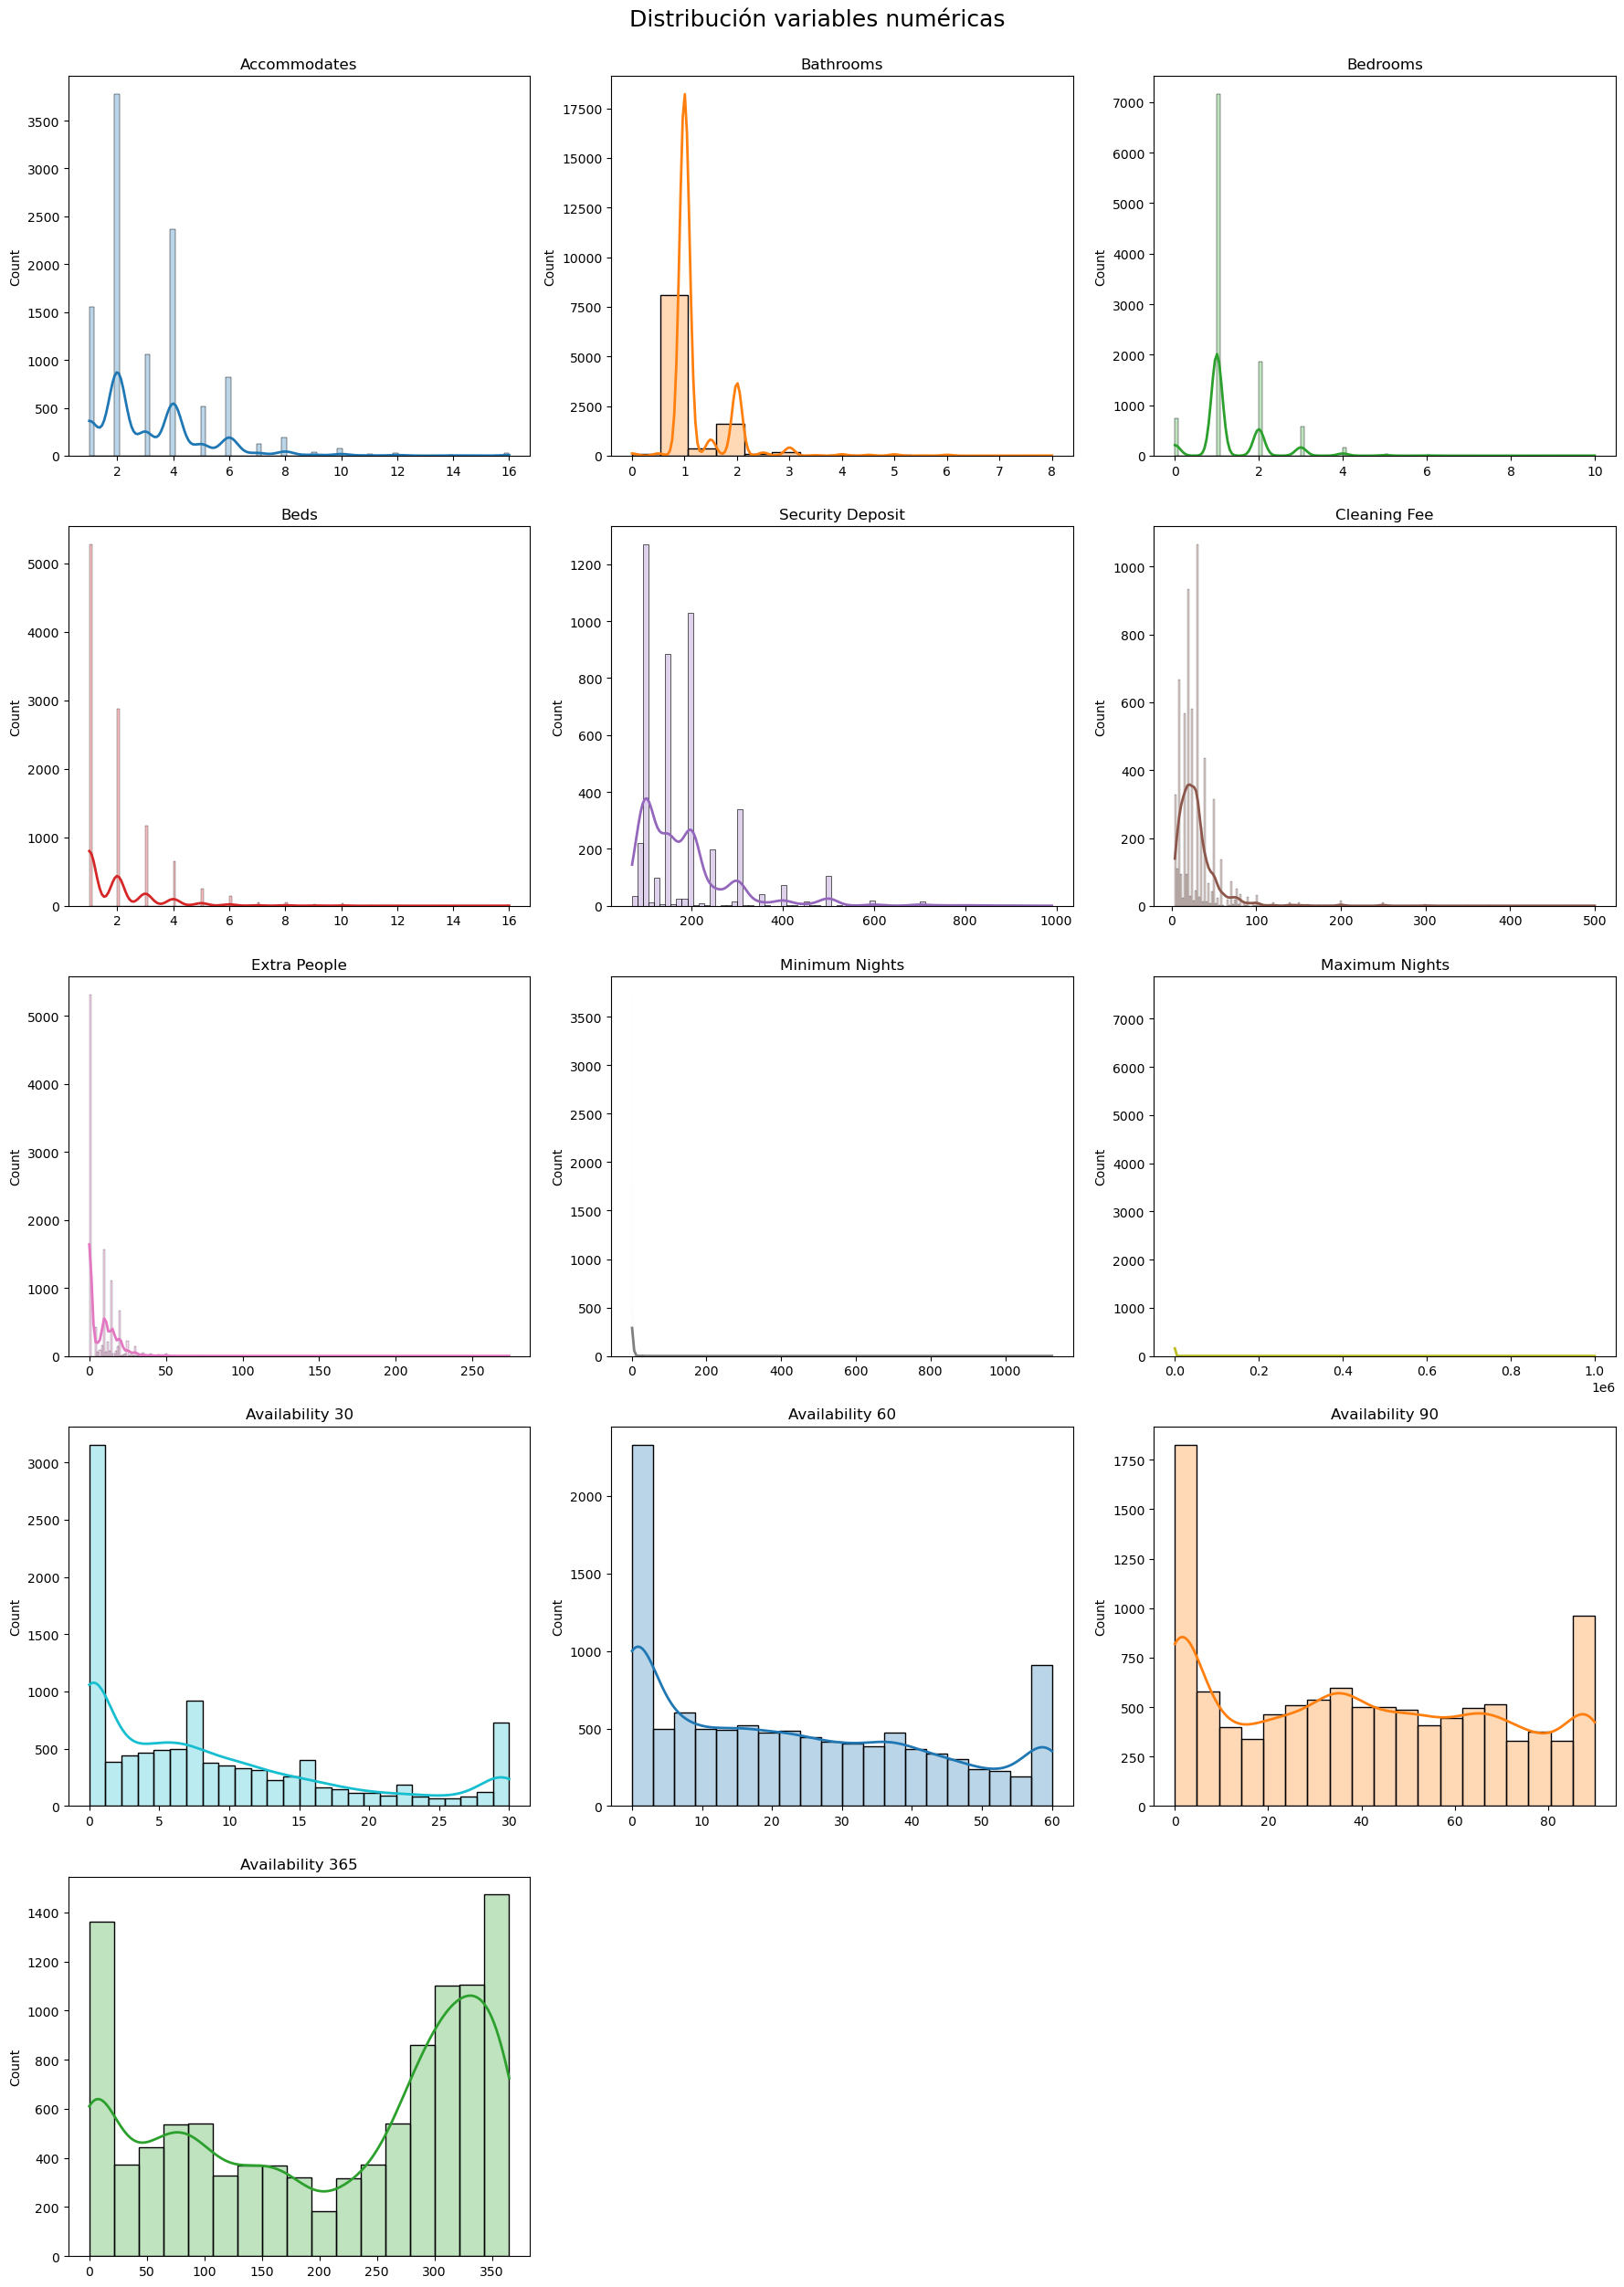

In [164]:
create_hist(df)

En la siguiente celda realizamos las gráficas scatter.

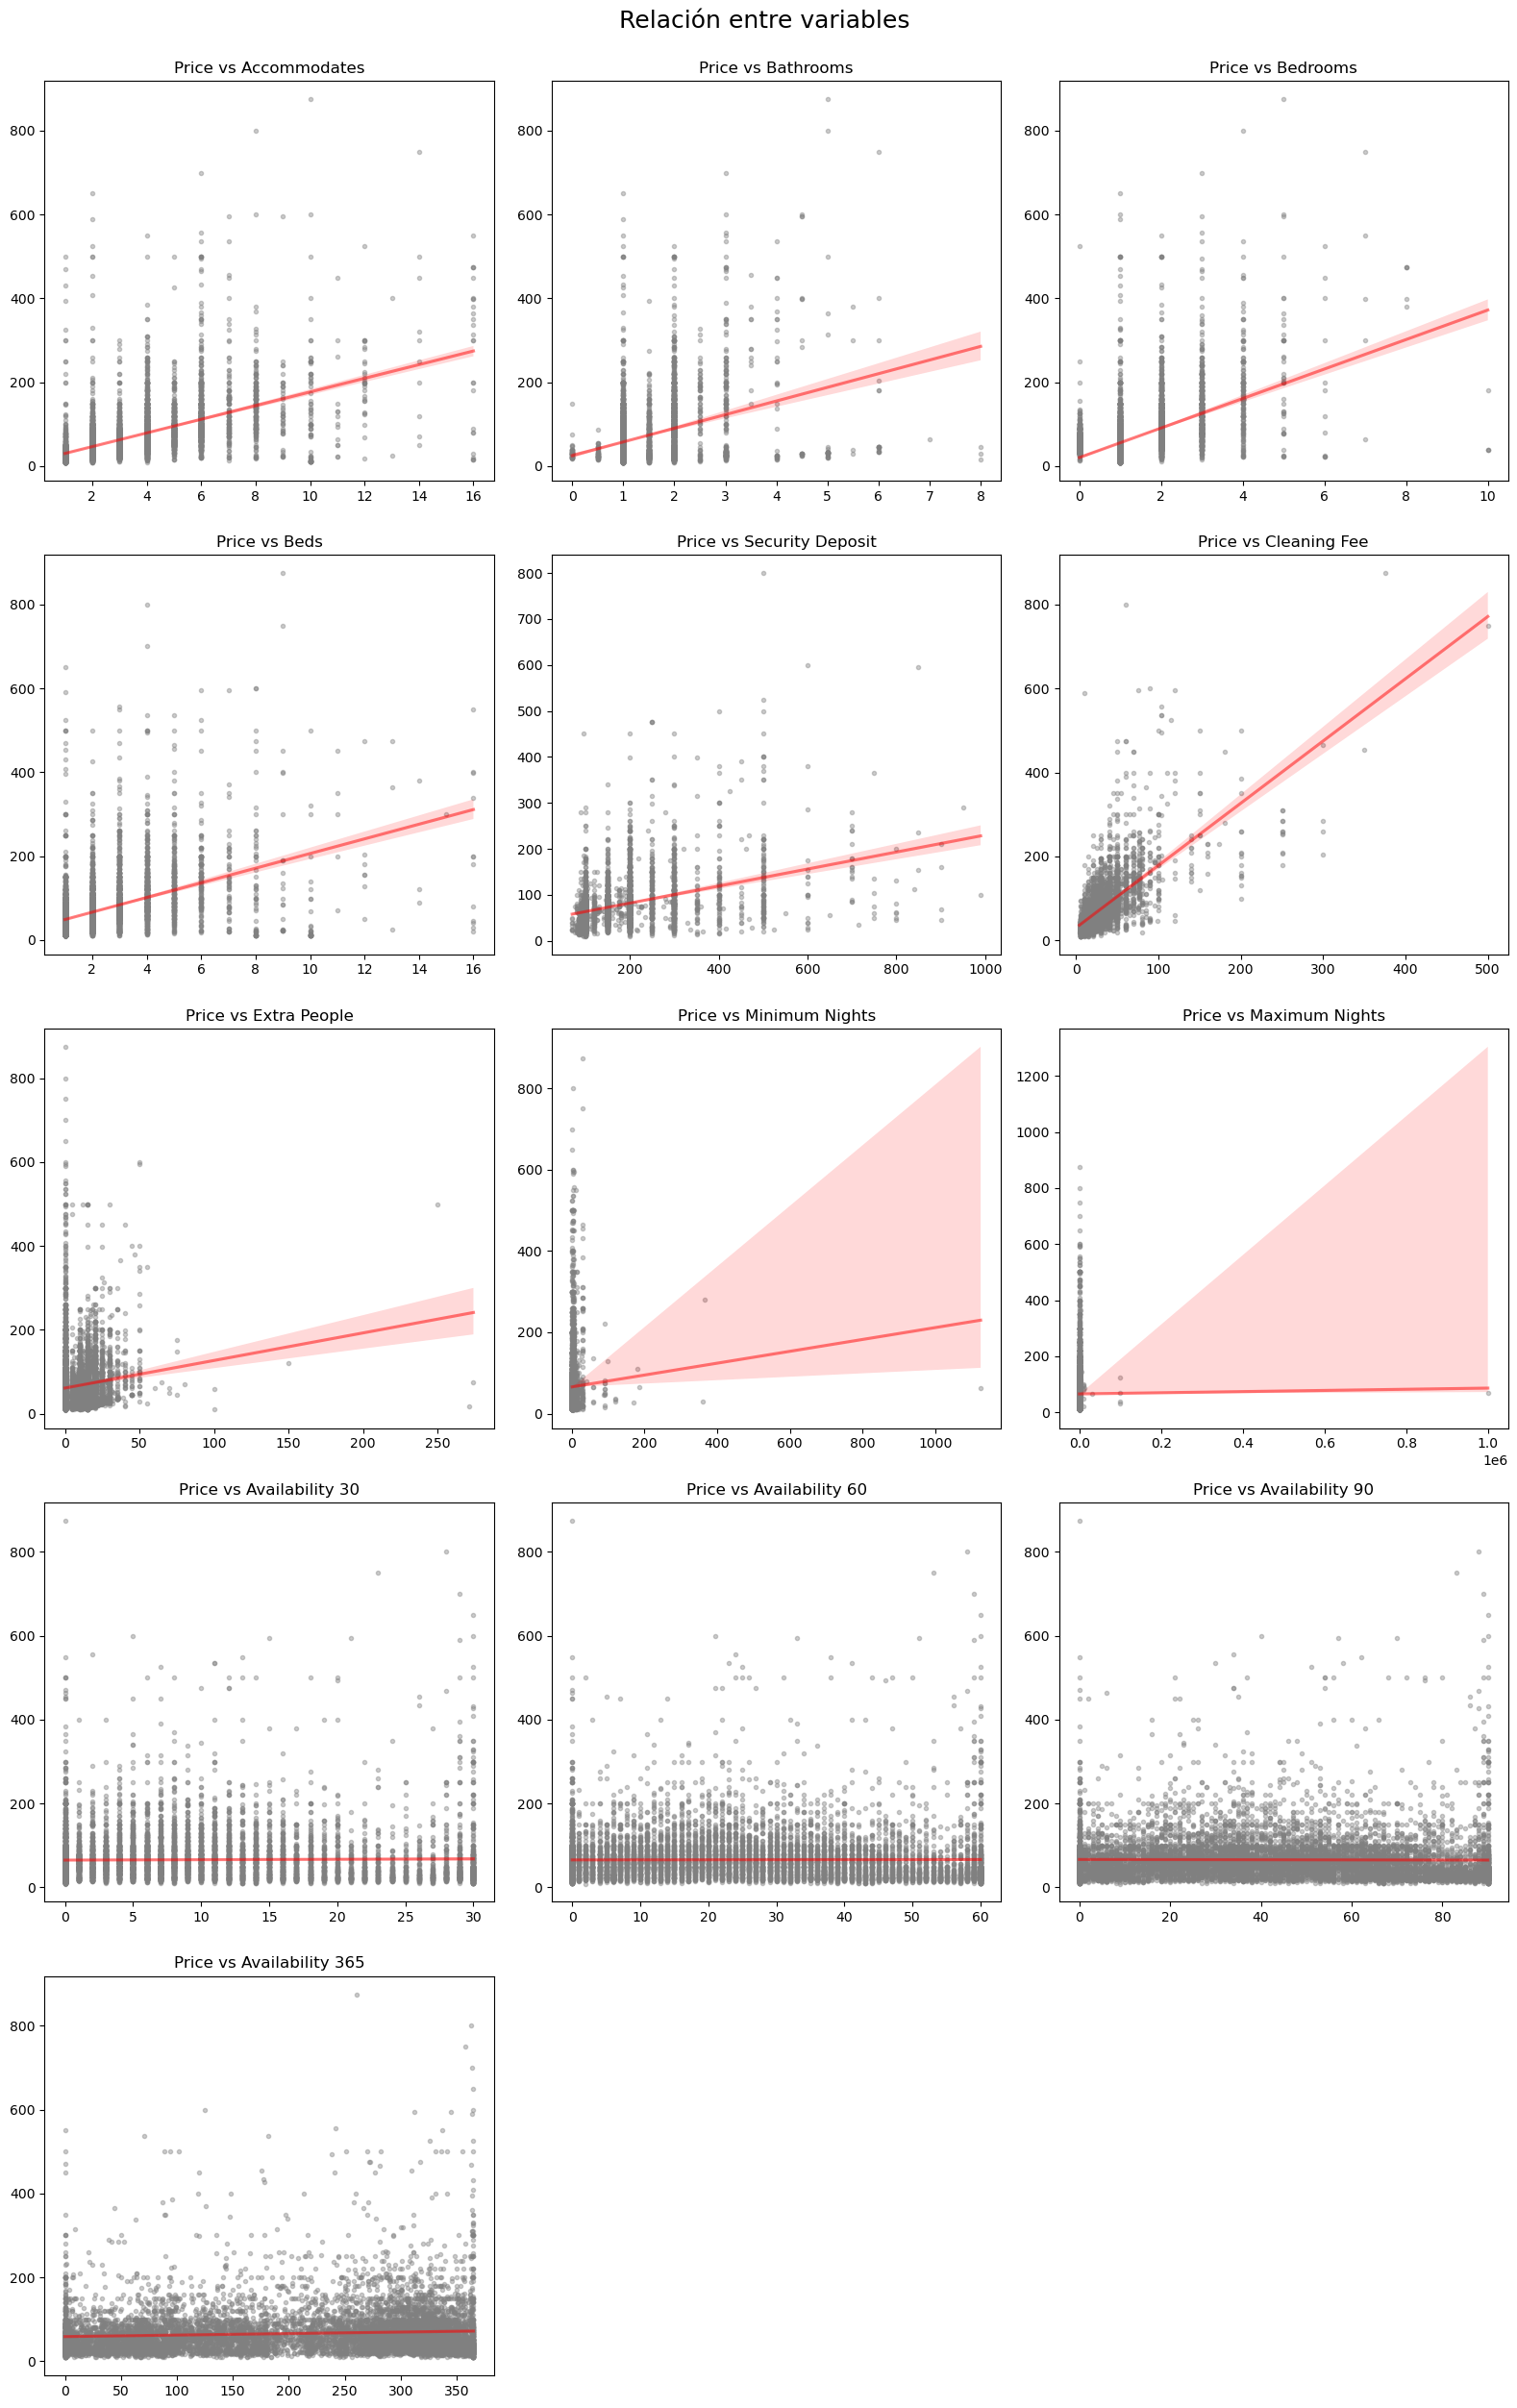

In [165]:
create_scatter(df)

Calculamos la matriz de correlación.

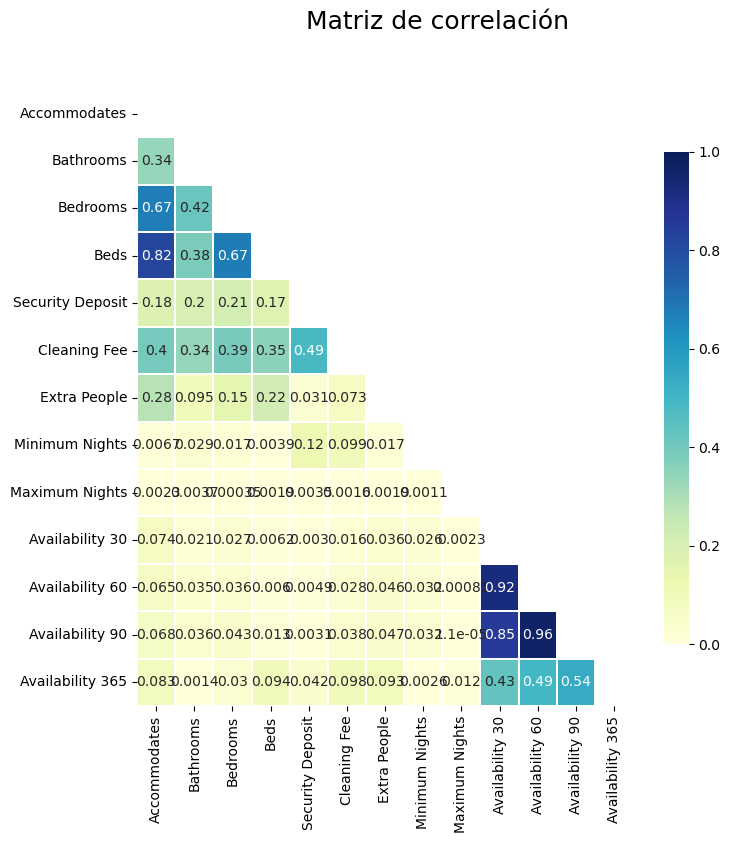

In [166]:
corr_matrix(df)

Tras visualizar los scatterplot observamos que hay variables que a priori se relacionan bastante con el precio, como pueden ser Accommodates, Bathrooms, Bedrooms, beds, Cleaning Fee y Extra People. En las siguientes celdas vamos a analizar un poco más a fondo las dos últimas dimensiones mencionadas. Además también observamos que 'Minimum Nights' y 'Maximum Nights' en principio aportarían poco al modelo por lo tanto las vamos a eliminar. Además vamos a eliminar las dimensiones de Availability por que tampoco parece que tengan una fuerte relación con el precio

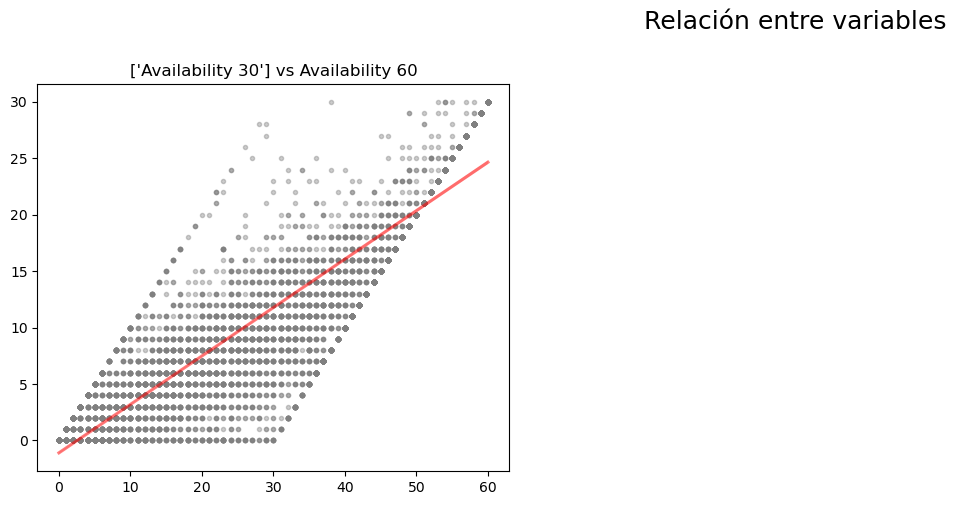

In [173]:
create_scatter(df, columns=['Availability 60'], y =['Availability 30'])

In [174]:
col_delete = ['Minimum Nights', 'Maximum Nights', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365' ]
df = first_trasnformation(df,col_delete)

**A pesar de que entiendo que no es del todo correcto vamos asumir que los alojamientos que no tienen asignado un valor de Cleaning Fee es por que no se cobra dicha tarifa, por lo que los pondremos a cero**

In [175]:
#rellenamos los Cleaning Fee Na con ceros
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

El Security Deposit, lo trasnformaremos a categórico donde 0 es que no se requiere depósito y 1 que si. Por otro lado para saber si el alojamiento tiene aire acondicionado y calefacción creamos dos columnas en donde indica (SI/NO). y por último convierte a dummies las 3 columnas trasnformadas para ello usaremos la funcion second_transformation.

In [176]:
#llamamos a la función second_transformation para realizar lo indicado
df = second_transformation(df)

Analizamos la variable Claning Fee en las que se observa valores que pueden ser posibles outliers

In [177]:
print('Resumen de la variable:')
print(df['Cleaning Fee'].describe())
print('-----------------------------------------------------------------------------')
filtered = (df['Cleaning Fee'][df['Cleaning Fee']>100])
print(f'Existen {filtered.shape[0]} valores de Cleaning Fee superiores a 100 euros, distribuidos de la siguiente manera:')
print(filtered.value_counts())
print('-----------------------------------------------------------------------------')
df[df['Cleaning Fee']>100].head(15)

Resumen de la variable:
count    10596.000000
mean        17.370706
std         24.498831
min          0.000000
25%          0.000000
50%         10.000000
75%         30.000000
max        500.000000
Name: Cleaning Fee, dtype: float64
-----------------------------------------------------------------------------
Existen 81 valores de Cleaning Fee superiores a 100 euros, distribuidos de la siguiente manera:
200.0    15
250.0    11
140.0    11
150.0     9
120.0     9
103.0     7
160.0     5
300.0     4
180.0     2
110.0     2
500.0     1
350.0     1
115.0     1
375.0     1
105.0     1
174.0     1
Name: Cleaning Fee, dtype: int64
-----------------------------------------------------------------------------


,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Cleaning Fee,Extra People,Cancellation Policy,A/C_NO,A/C_SI,Heat_NO,Heat_SI,Sec_Dep_NO,Sec_Dep_SI
8,Salamanca,Apartment,Entire home/apt,6,3.0,3.0,5.0,Real Bed,465.0,300.0,0,strict,0,1,0,1,1,0
134,Centro,Apartment,Entire home/apt,16,6.0,6.0,16.0,Real Bed,400.0,150.0,0,strict,0,1,0,1,0,1
206,Chamberí,Apartment,Entire home/apt,8,3.5,4.0,6.0,Real Bed,280.0,180.0,0,strict,0,1,0,1,0,1
434,Salamanca,Apartment,Entire home/apt,4,2.0,2.0,4.0,Real Bed,310.0,250.0,0,strict,0,1,0,1,1,0
838,Centro,Apartment,Entire home/apt,16,4.5,7.0,9.0,Real Bed,399.0,110.0,15,strict,1,0,0,1,0,1
890,Hortaleza,House,Entire home/apt,10,3.5,4.0,5.0,Real Bed,350.0,150.0,50,strict,0,1,0,1,0,1
1329,Chamberí,Apartment,Entire home/apt,5,2.0,3.0,4.0,Real Bed,150.0,140.0,0,strict,0,1,0,1,0,1
1376,Salamanca,Apartment,Entire home/apt,9,2.0,3.0,4.0,Real Bed,190.0,120.0,30,strict,0,1,0,1,1,0
1620,Chamberí,Apartment,Entire home/apt,6,2.5,3.0,5.0,Real Bed,220.0,140.0,0,strict,0,1,0,1,0,1
1735,Tetuán,Apartment,Entire home/apt,4,1.5,2.0,4.0,Real Bed,207.0,250.0,0,strict,0,1,0,1,1,0


Vamos a optar por la eliminación de la variable Cleaning Fee, ya que existen bastantes valores elevados y que analizando un poco el dataser filtrado 
parece que éste importe tiene bastante relación con el mínimo de noches de alojamiento.

In [178]:
col_delete = ['Cleaning Fee']
df = first_trasnformation(df,col_delete)

Analizamos la variable Extra People

In [179]:
print('Resumen de la variable:')
print(df['Extra People'].describe())
print('-----------------------------------------------------------------------------')
filtered = (df['Extra People'][df['Extra People']>60])
print(f'Existen {filtered.shape[0]} valores de Cleaning Fee superiores a 100 euros, distribuidos de la siguiente manera:')
print(filtered.value_counts())
print('-----------------------------------------------------------------------------')
df[df['Extra People']>30].head(15)

Resumen de la variable:
count    10596.000000
mean         7.413364
std         10.530548
min          0.000000
25%          0.000000
50%          0.000000
75%         14.000000
max        274.000000
Name: Extra People, dtype: float64
-----------------------------------------------------------------------------
Existen 14 valores de Cleaning Fee superiores a 100 euros, distribuidos de la siguiente manera:
75     3
250    2
100    2
70     2
80     1
65     1
274    1
150    1
271    1
Name: Extra People, dtype: int64
-----------------------------------------------------------------------------


,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Extra People,Cancellation Policy,A/C_NO,A/C_SI,Heat_NO,Heat_SI,Sec_Dep_NO,Sec_Dep_SI
378,Centro,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,95.0,50,flexible,0,1,0,1,0,1
459,Arganzuela,Condominium,Private room,2,1.0,1.0,2.0,Real Bed,30.0,50,moderate,1,0,0,1,1,0
714,Retiro,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,70.0,40,strict,1,0,0,1,0,1
819,Chamberí,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,75.0,45,strict,0,1,0,1,0,1
890,Hortaleza,House,Entire home/apt,10,3.5,4.0,5.0,Real Bed,350.0,50,strict,0,1,0,1,0,1
951,Centro,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,50.0,50,flexible,1,0,0,1,0,1
953,Centro,Apartment,Entire home/apt,3,1.0,0.0,2.0,Pull-out Sofa,125.0,35,strict,0,1,0,1,0,1
989,Centro,House,Entire home/apt,9,3.0,3.0,7.0,Real Bed,146.0,39,flexible,0,1,0,1,1,0
1161,Chamberí,Bed & Breakfast,Private room,2,6.0,1.0,1.0,Real Bed,45.0,45,strict,0,1,0,1,0,1
1222,Centro,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,80.0,45,strict,1,0,0,1,0,1


Por último vamos a eliminar tambiés esta variable por que apriori no parece muy fiable, ya que tiene valores de extrapeople muy altos para alojamientos
muy pequeños 

In [180]:
col_delete = ['Extra People']
df = first_trasnformation(df,col_delete)

In [181]:
pd.options.display.max_rows=100
df.dtypes

Neighbourhood Group Cleansed     object
Property Type                    object
Room Type                        object
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                         object
Price                           float64
Cancellation Policy              object
A/C_NO                            uint8
A/C_SI                            uint8
Heat_NO                           uint8
Heat_SI                           uint8
Sec_Dep_NO                        uint8
Sec_Dep_SI                        uint8
dtype: object

**Variables categóricas**

In [182]:
df.select_dtypes(include=['object']).describe()

,Neighbourhood Group Cleansed,Property Type,Room Type,Bed Type,Cancellation Policy
count,10596,10596,10596,10596,10596
unique,21,21,3,5,5
top,Centro,Apartment,Entire home/apt,Real Bed,strict
freq,5418,8717,6324,10378,4004


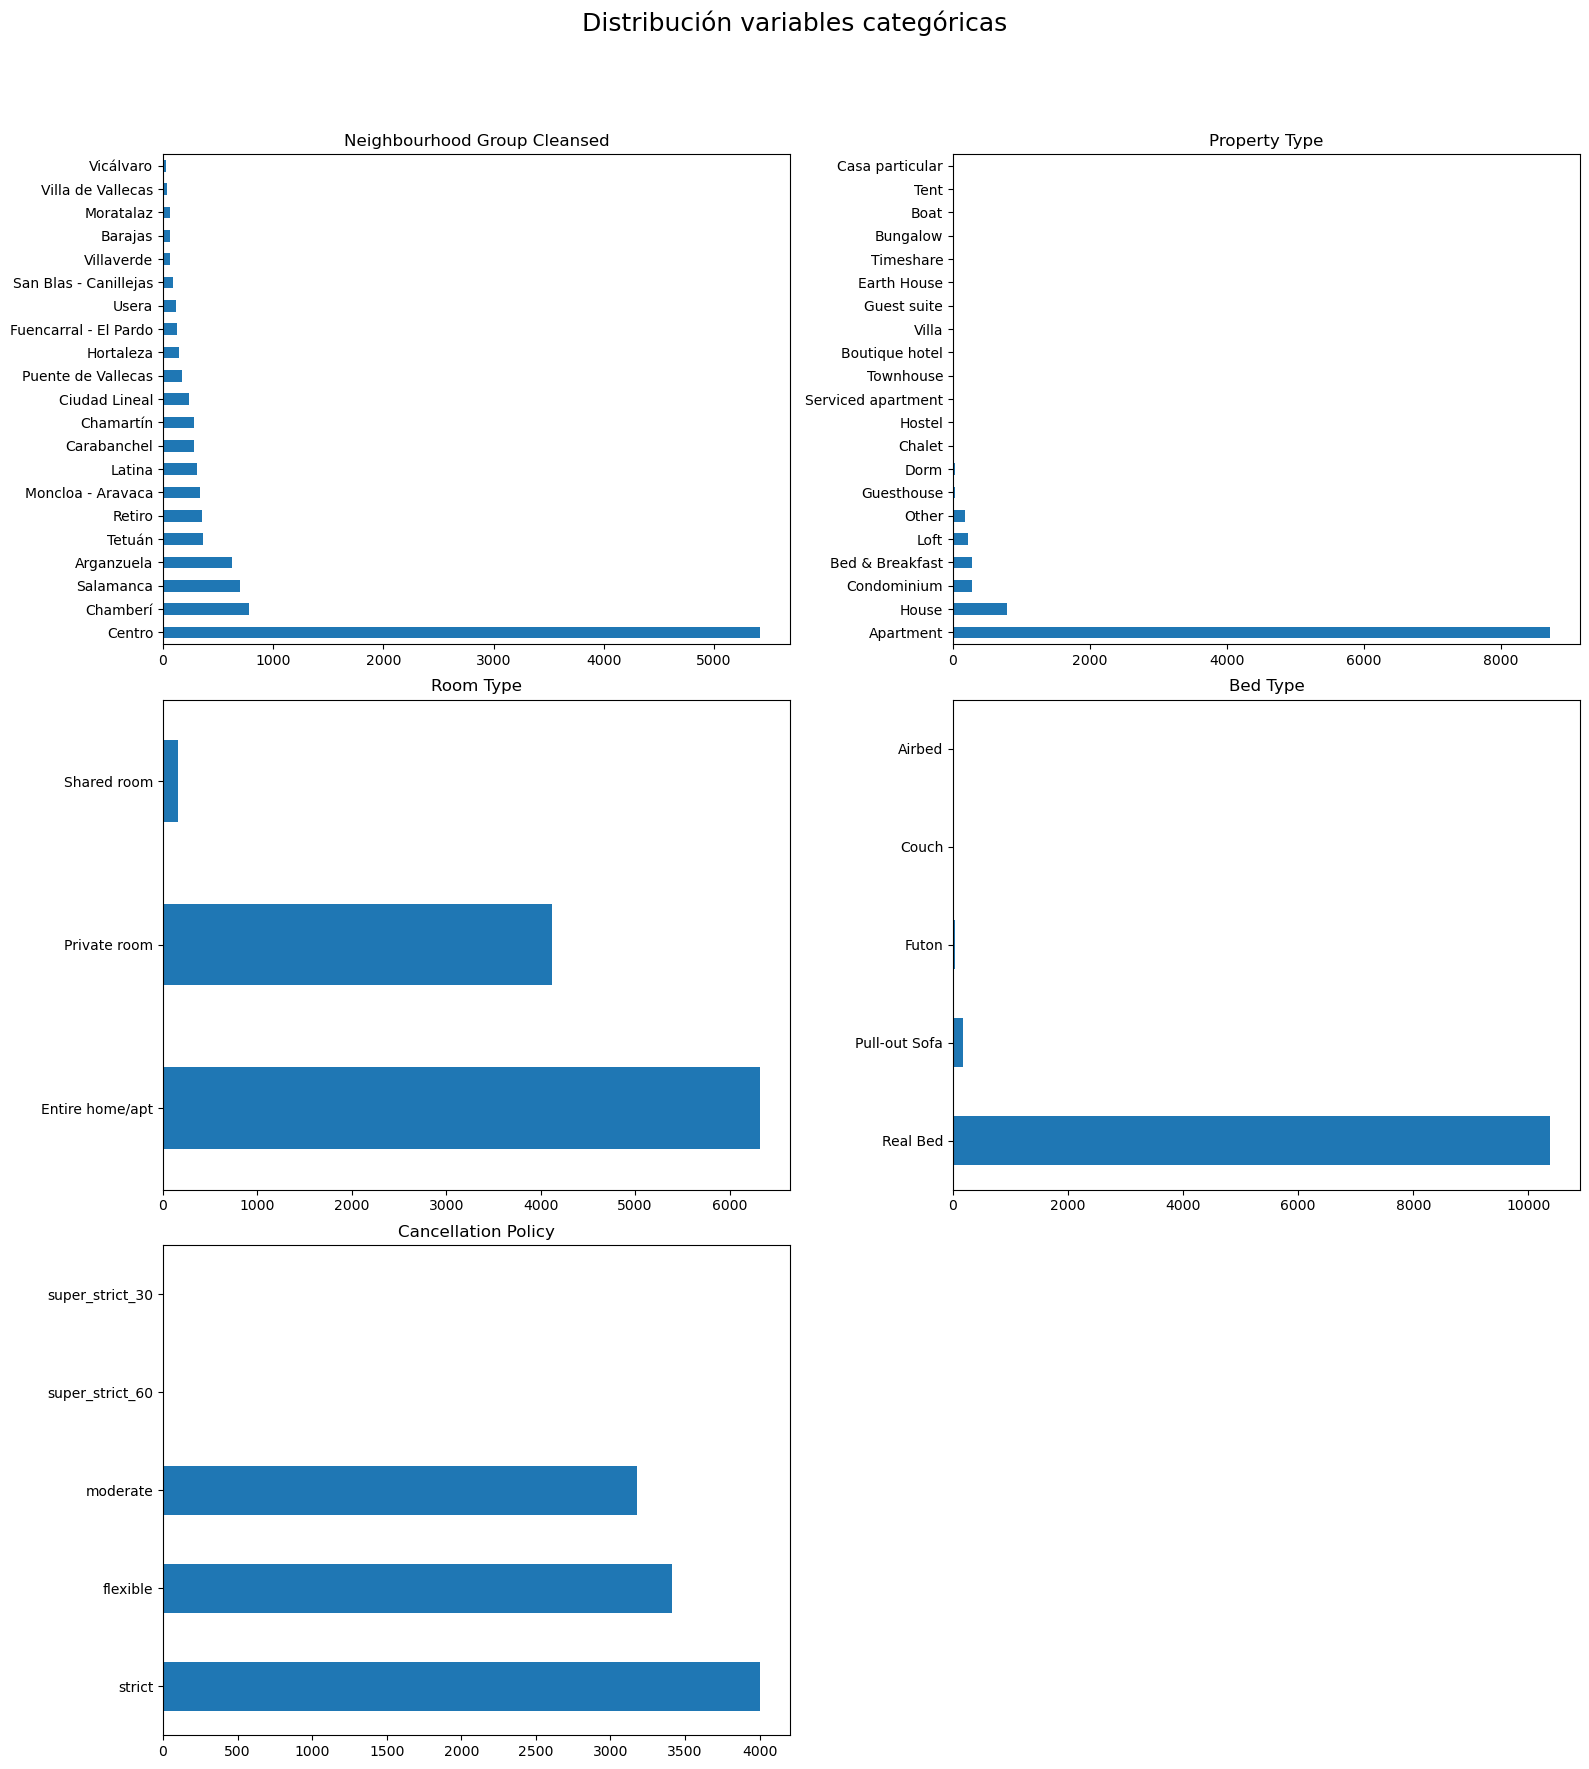

In [183]:
create_dist_categ(df)

In [184]:
df['Cancellation Policy'].value_counts()

strict             4004
flexible           3413
moderate           3176
super_strict_60       2
super_strict_30       1
Name: Cancellation Policy, dtype: int64

Vamos a reagrupar los niveles reagrupando los que contienen strict en strict


In [185]:
list_index_canc_Pol = df['Cancellation Policy'].value_counts().index[0:3] 
#Usamos la unción regroup_values para cambiar los nombres de los niveles 
regroup_values(df,'Cancellation Policy',list_index_canc_Pol, new_value='strict')

In [186]:
#Comprobamos si se hizo correctamente el reagrupamiento
df['Cancellation Policy'].value_counts()

strict      4007
flexible    3413
moderate    3176
Name: Cancellation Policy, dtype: int64

In [187]:
df['Property Type'].value_counts()

Apartment             8717
House                  784
Condominium            285
Bed & Breakfast        283
Loft                   218
Other                  178
Guesthouse              33
Dorm                    33
Chalet                  17
Hostel                  12
Serviced apartment      11
Townhouse                7
Boutique hotel           4
Villa                    3
Guest suite              3
Earth House              3
Timeshare                1
Bungalow                 1
Boat                     1
Tent                     1
Casa particular          1
Name: Property Type, dtype: int64

Vamos a reagrupar los niveles manteniendo hasta loft y el resto los reagruparemos en Other

In [188]:
list_index_prop_type = df['Property Type'].value_counts().index[0:5] #Creamos una lista con los valores que mantendremos
#Usamos la unción regroup_values para cambiar los nombres de los niveles 
regroup_values(df,'Property Type',list_index_prop_type)

In [189]:
#Comprobamos el reagrupapiemnto
df['Property Type'].value_counts()

Apartment          8717
House               784
Other               309
Condominium         285
Bed & Breakfast     283
Loft                218
Name: Property Type, dtype: int64

Realizamos lo mismo con Bed Type

In [190]:
df['Bed Type'].value_counts()

Real Bed         10378
Pull-out Sofa      177
Futon               28
Couch                9
Airbed               4
Name: Bed Type, dtype: int64

In [191]:
list_index_bed_type = df['Bed Type'].value_counts().index[0:2] 
#Usamos la unción regroup_values para cambiar los nombres de los niveles 
regroup_values(df,'Bed Type',list_index_bed_type)

In [192]:
df['Bed Type'].value_counts()

Real Bed         10378
Pull-out Sofa      177
Other               41
Name: Bed Type, dtype: int64

Realizamos los boxplots para ver como se distribuye el precio por categorias

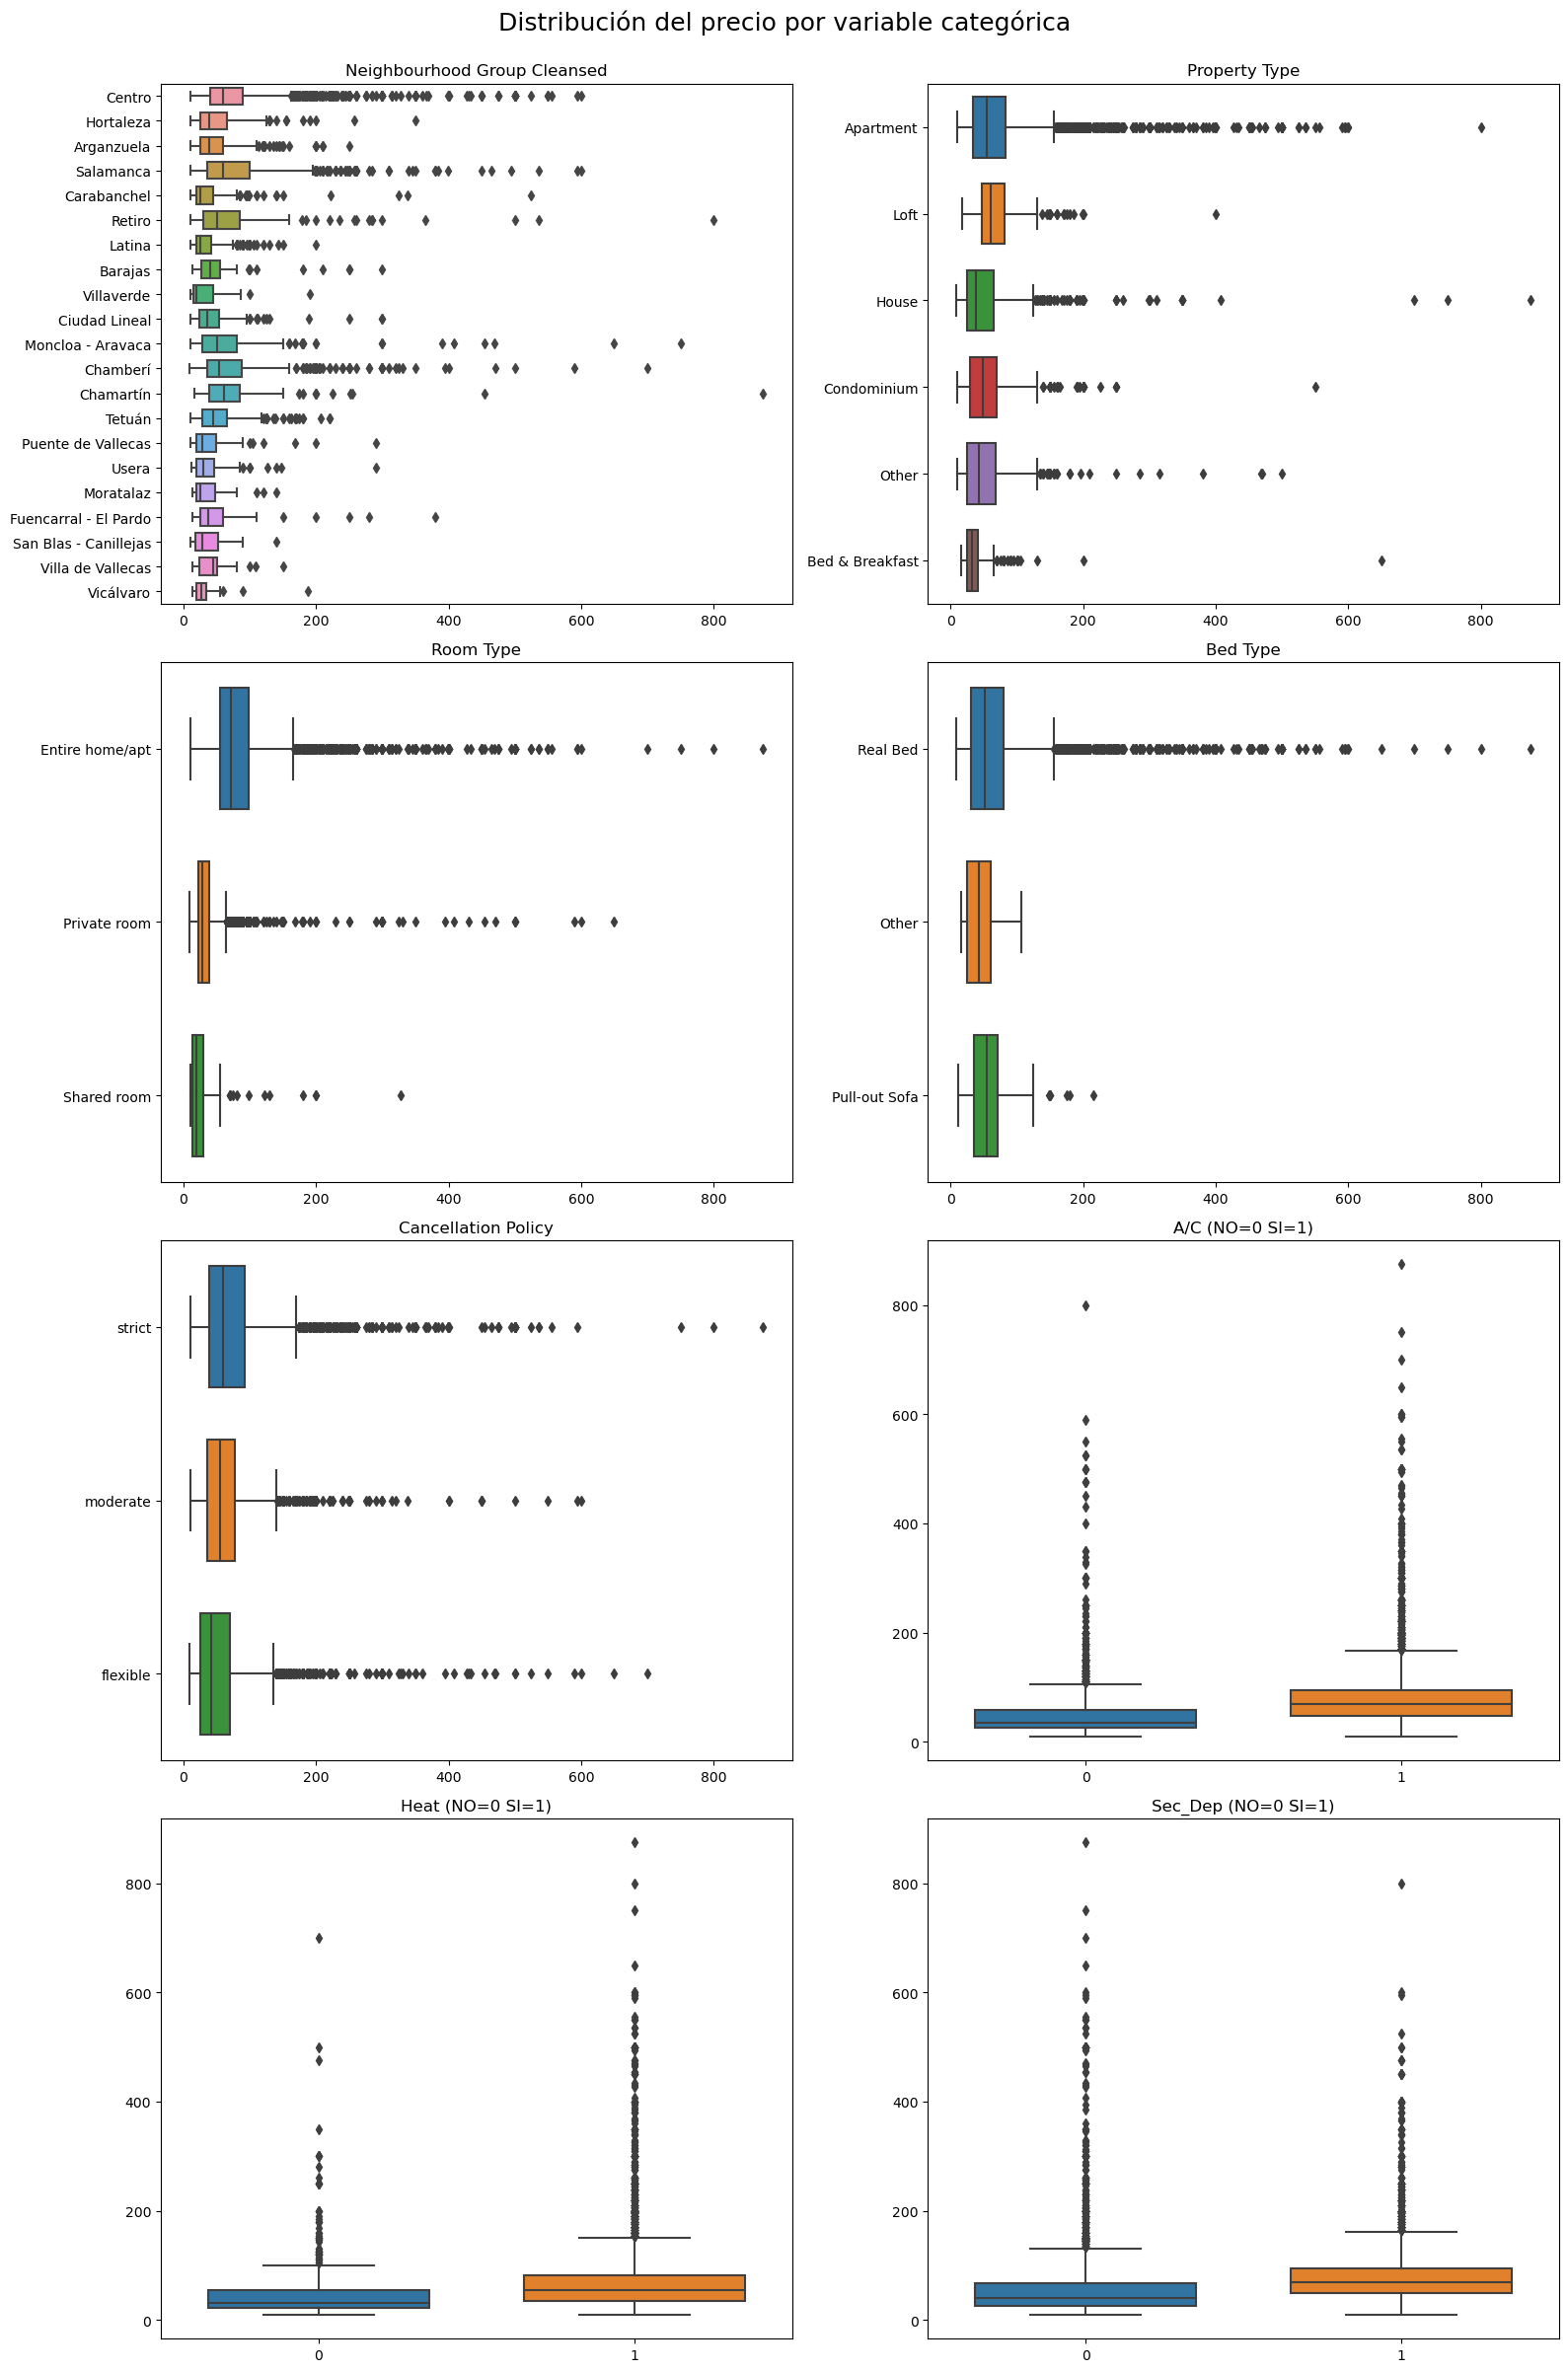

In [193]:
create_boxplot(df)

Ahora vamos a realizar la trasnformación de las variables ['Neighbourhood_Group_Cleansed','Property_Type','Room_Type', 'Bed_Type', 'Cancellation_Policy'],  mediante MeanEncoder de la libreria 
Feature_engine

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neighbourhood Group Cleansed  10596 non-null  object 
 1   Property Type                 10596 non-null  object 
 2   Room Type                     10596 non-null  object 
 3   Accommodates                  10596 non-null  int64  
 4   Bathrooms                     10559 non-null  float64
 5   Bedrooms                      10580 non-null  float64
 6   Beds                          10558 non-null  float64
 7   Bed Type                      10596 non-null  object 
 8   Price                         10588 non-null  float64
 9   Cancellation Policy           10596 non-null  object 
 10  A/C_NO                        10596 non-null  uint8  
 11  A/C_SI                        10596 non-null  uint8  
 12  Heat_NO                       10596 non-null  uint8  
 13  H

In [195]:
df.describe()

,Accommodates,Bathrooms,Bedrooms,Beds,Price,A/C_NO,A/C_SI,Heat_NO,Heat_SI,Sec_Dep_NO,Sec_Dep_SI
count,10596.000000,10559.000000,10580.000000,10558.000000,10588.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000
mean,3.190260,1.251776,1.291210,1.991760,66.068946,0.441770,0.558230,0.081635,0.918365,0.577293,0.422707
std,2.000907,0.602483,0.822789,1.527565,56.414585,0.496621,0.496621,0.273820,0.273820,0.494013,0.494013
min,1.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,2.000000,52.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,4.000000,1.000000,2.000000,2.000000,80.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,16.000000,8.000000,10.000000,16.000000,875.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


primero generamos las variables x_train e y_train

In [196]:
new_index = ['Neighbourhood Group Cleansed',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Cancellation Policy',
       'A/C_NO', 'A/C_SI', 'Heat_NO', 'Heat_SI', 'Sec_Dep_NO', 'Sec_Dep_SI','Price']
df = df.dropna()
df =  df.reindex(columns = new_index)
#modificamos el nombre de las columnas para que no haya espacios si no la función MeanEncoder nos daría problemas
df.columns = ['Neighbourhood_Group_Cleansed',
       'Property_Type', 'Room_Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed_Type', 'Cancellation_Policy',
       'A/C_NO', 'A/C_SI', 'Heat_NO', 'Heat_SI', 'Sec_Dep_NO', 'Sec_Dep_SI','Price']
y_train = df['Price']                   # nos quedamos con la última columna, price
X_train = df.drop('Price',axis =1)      # nos quedamos con el resto

In [197]:
main_encoder_categorical = MeanEncoder(variables=['Neighbourhood_Group_Cleansed','Property_Type','Room_Type', 'Bed_Type', 'Cancellation_Policy'])

In [198]:
main_encoder_categorical.fit(X_train, y_train)

MeanEncoder(variables=['Neighbourhood_Group_Cleansed', 'Property_Type',
                       'Room_Type', 'Bed_Type', 'Cancellation_Policy'])

In [199]:
main_encoder_categorical.encoder_dict_

{'Neighbourhood_Group_Cleansed': {'Arganzuela': 46.306946688206786,
  'Barajas': 56.854838709677416,
  'Carabanchel': 39.157706093189965,
  'Centro': 73.19031719532555,
  'Chamartín': 72.43165467625899,
  'Chamberí': 73.02325581395348,
  'Ciudad Lineal': 43.81856540084388,
  'Fuencarral - El Pardo': 50.578512396694215,
  'Hortaleza': 53.8,
  'Latina': 34.320388349514566,
  'Moncloa - Aravaca': 67.6,
  'Moratalaz': 36.016949152542374,
  'Puente de Vallecas': 37.27485380116959,
  'Retiro': 70.28169014084507,
  'Salamanca': 84.37031700288185,
  'San Blas - Canillejas': 36.95652173913044,
  'Tetuán': 52.93646408839779,
  'Usera': 39.78151260504202,
  'Vicálvaro': 36.46153846153846,
  'Villa de Vallecas': 44.743589743589745,
  'Villaverde': 32.546875},
 'Property_Type': {'Apartment': 67.97958712951217,
  'Bed & Breakfast': 38.135714285714286,
  'Condominium': 61.540636042402824,
  'House': 57.316946959896505,
  'Loft': 71.17511520737327,
  'Other': 60.71854304635762},
 'Room_Type': {'Entire

In [200]:
X_train = main_encoder_categorical.transform(X_train)

In [249]:
X_train

array([[ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883],
       [ 0.51269579,  0.90947312,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883],
       ...,
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883]])

**Volvemos a visualizar los datos en graficas**

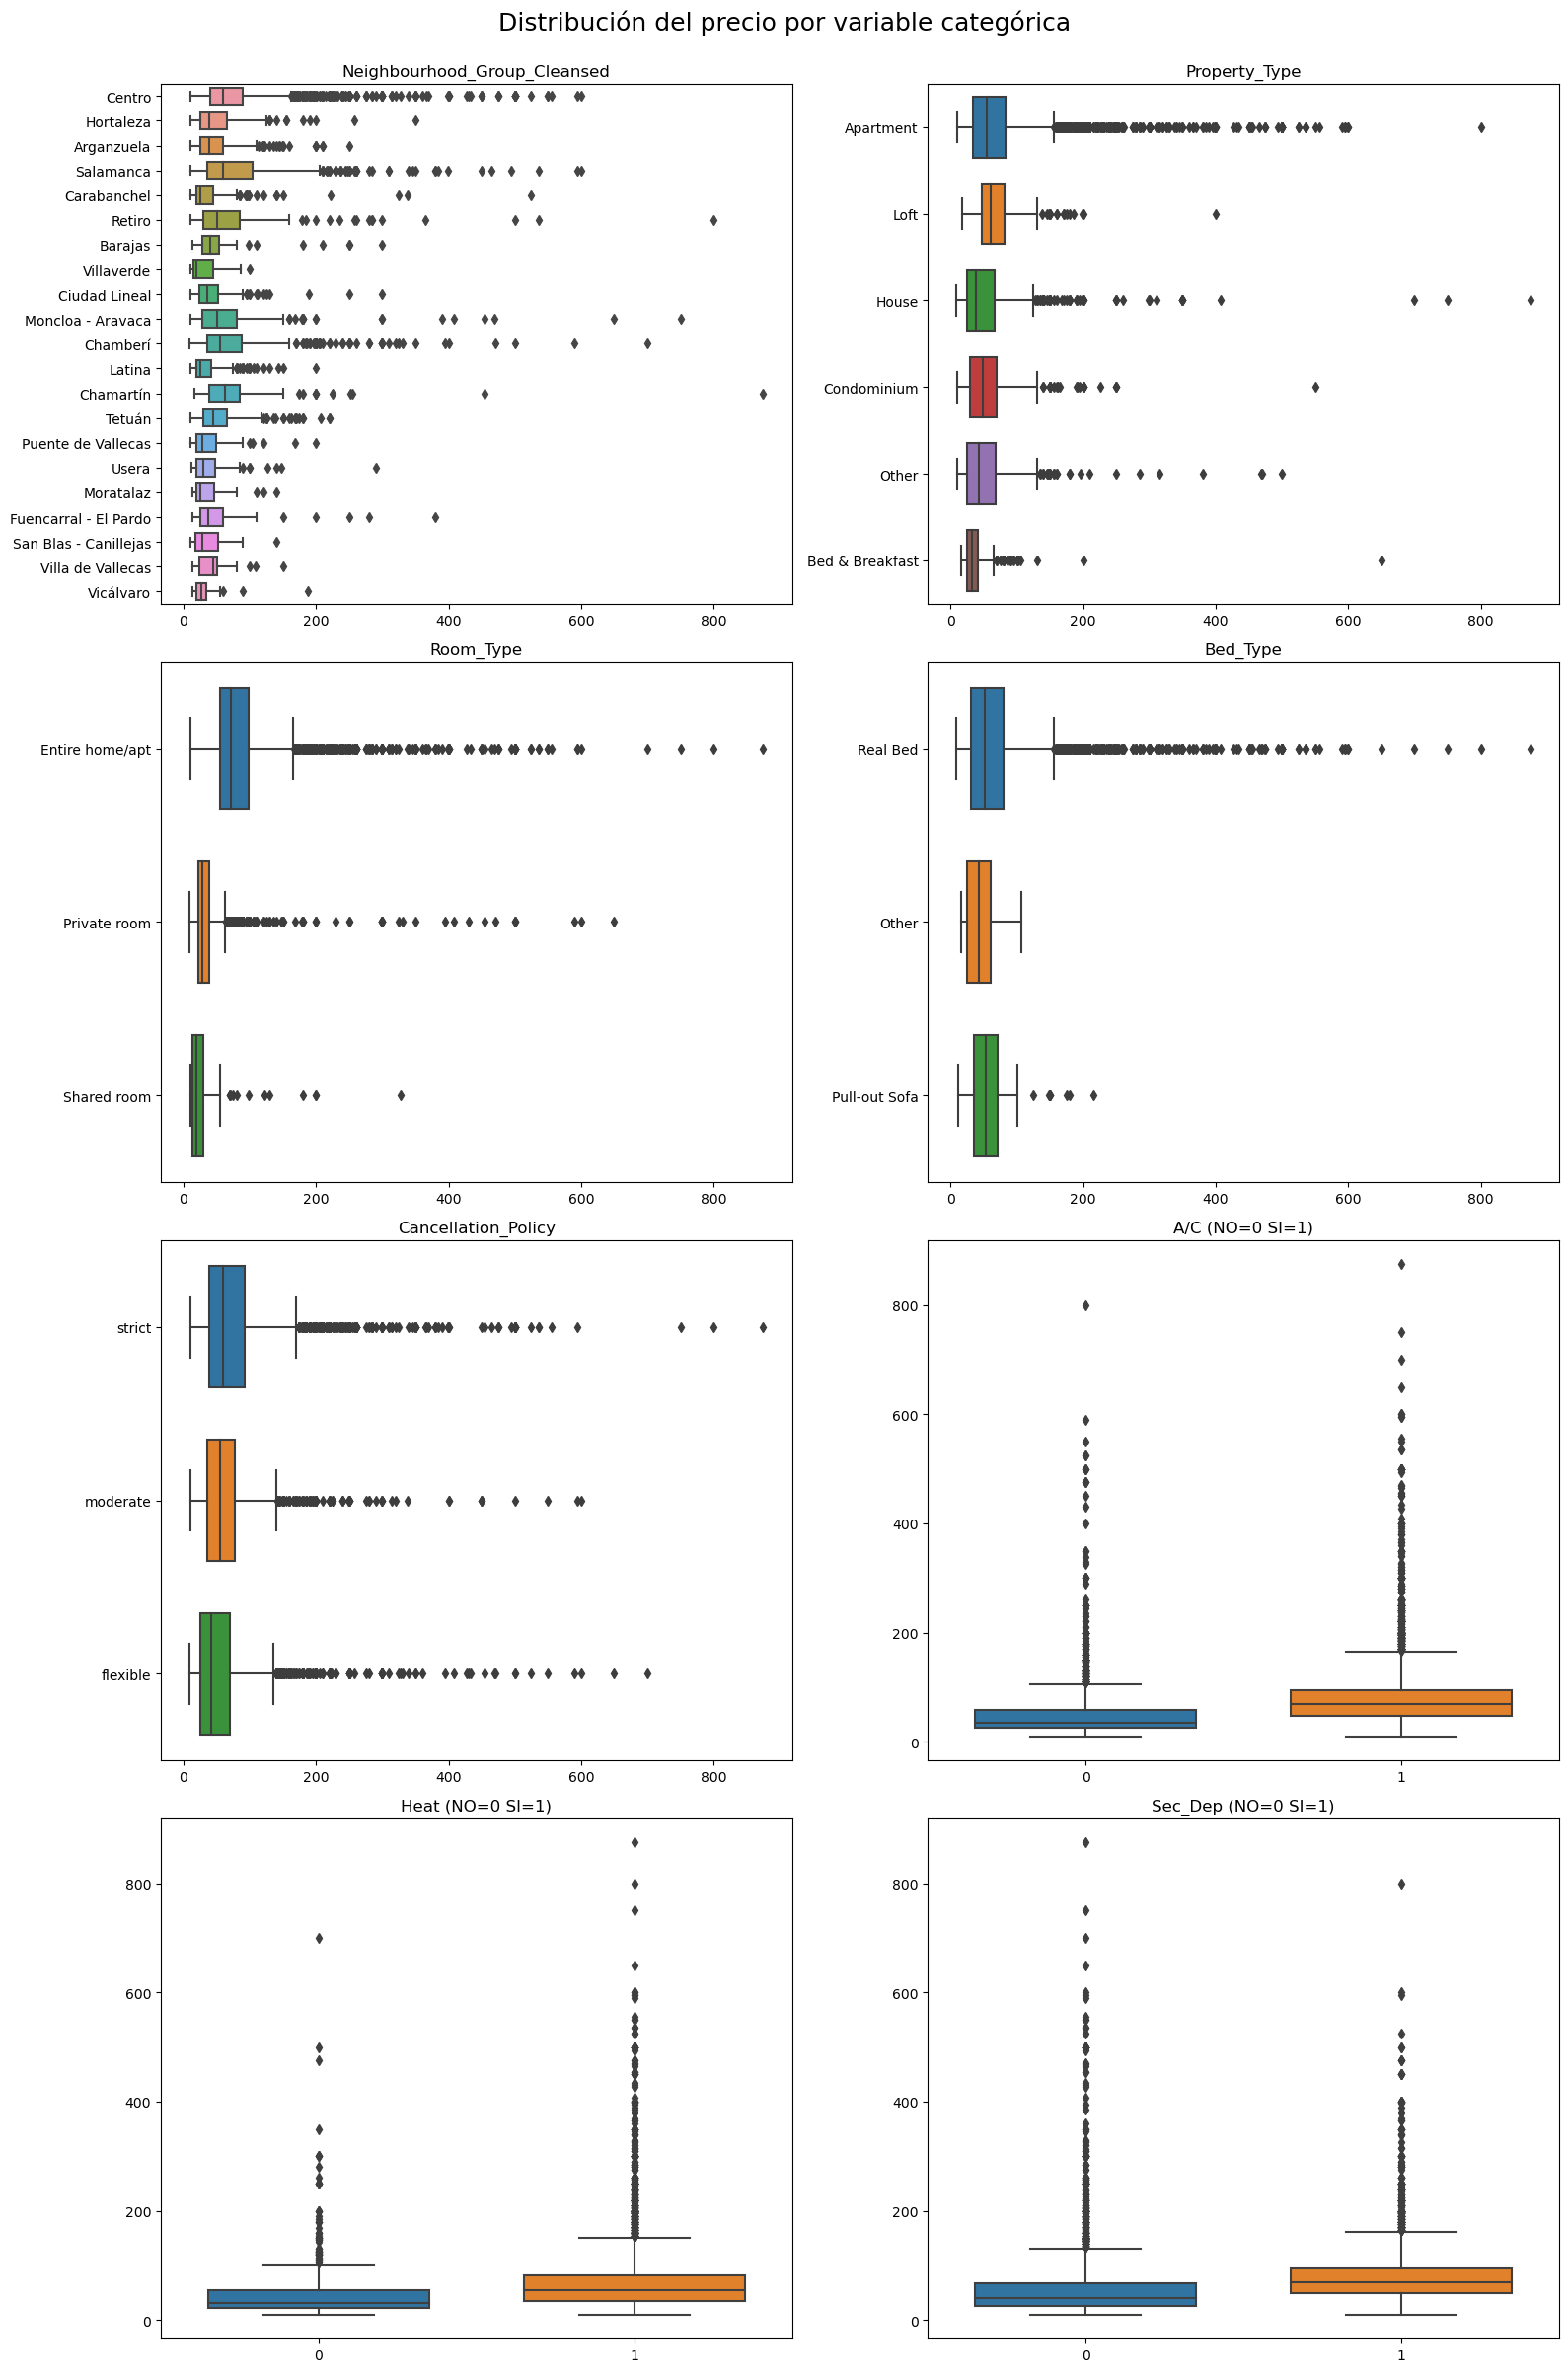

In [202]:
create_boxplot(df)

In [203]:
X_train

,Neighbourhood_Group_Cleansed,Property_Type,Room_Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type,Cancellation_Policy,A/C_NO,A/C_SI,Heat_NO,Heat_SI,Sec_Dep_NO,Sec_Dep_SI
0,73.190317,67.979587,87.603207,4,1.0,1.0,2.0,66.317587,76.680883,0,1,0,1,1,0
1,73.190317,67.979587,87.603207,7,2.0,3.0,3.0,66.317587,76.680883,0,1,0,1,0,1
2,73.190317,71.175115,87.603207,4,1.0,1.0,2.0,66.317587,76.680883,1,0,0,1,0,1
3,73.190317,67.979587,34.192487,2,0.5,1.0,1.0,66.317587,76.680883,1,0,1,0,1,0
4,53.800000,67.979587,34.192487,1,1.0,1.0,1.0,66.317587,62.440265,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10590,73.190317,67.979587,29.948387,1,1.0,1.0,1.0,66.317587,56.997038,1,0,1,0,1,0
10591,52.936464,67.979587,87.603207,6,1.5,3.0,4.0,66.317587,56.997038,0,1,0,1,1,0
10592,73.190317,67.979587,87.603207,4,1.0,2.0,3.0,66.317587,56.997038,1,0,0,1,1,0
10593,73.190317,67.979587,87.603207,6,1.0,1.0,4.0,66.317587,62.440265,0,1,0,1,1,0


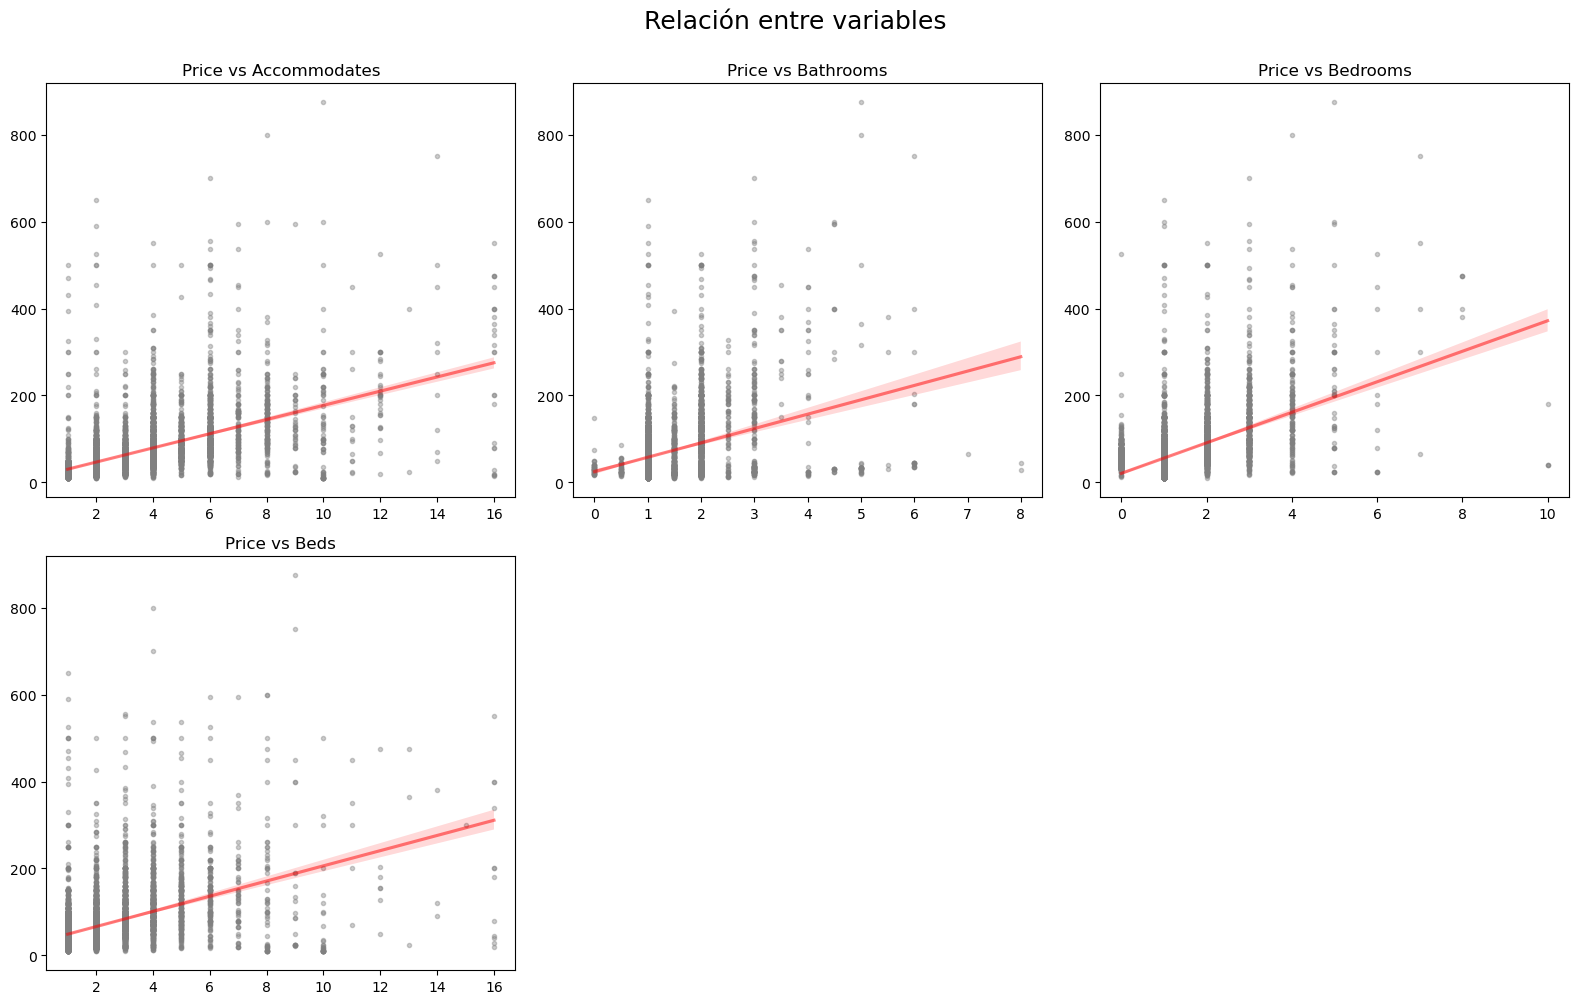

In [204]:
create_scatter(df)

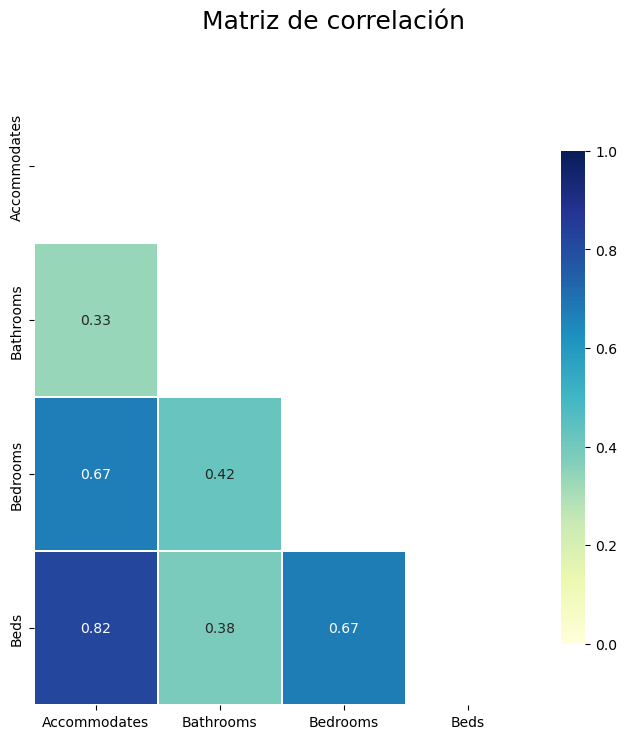

In [205]:
corr_matrix(df)

En base a la matriz de correlación observamos que las dimensiones Beds y Accommodates están muy correladas como es obvio. Aun asi no llega al humbral marcado de 0.9 asique mantendremos las dos

**Estandarizamos los datos**

Vamos a modificar el indice de las columnas para pasar la variable buscada a la última columna

In [211]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [212]:
X_train

array([[ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883],
       [ 0.51269579,  0.90947312,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883],
       ...,
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
         0.85746465, -0.85746465],
       [ 0.51269579,  0.33827653,  0.81919203, ...,  0.29884735,
        -1.16622883,  1.16622883]])

**Hemos realizado el análisis y la transformación del dataset, para ello hemos creado varias funciones que realizan todas las trasnforaciones paso a paso y que
usaremos para realizar la trasnformación del grupo de test. El siguiente código realiza la trasnformación al df test**

In [307]:
#Cargamos el df test
df_test = pd.read_csv('dataframes/test.csv', sep=';', decimal='.')

#Variables necesarias para la trasnformación:
colums_to_remove_test = ['ID','Host ID','Listing Url','Scrape ID','Last Scraped','Name','Summary','Space','Description','Experiences Offered','Neighborhood Overview','Notes','Transit',
                    'Access','Interaction','House Rules','Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Name','Host About', 'Host Response Rate',
                    'Calculated host listings count','Host Thumbnail Url','Host Picture Url','Host Verifications','Features','Square Feet','Host Acceptance Rate','Has Availability',
                    'Jurisdiction Names','Latitude','Longitude','Weekly Price','Monthly Price','Country','License','Geolocation','Calendar last Scraped','Calendar Updated','Square Feet',
                    'Host Neighbourhood','Host Response Time','Reviews per Month','First Review','Last Review','Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
                    'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value','Reviews per Month','Neighbourhood','Market','State','Zipcode',
                    'Smart Location','Country Code','Host Location','Host Listings Count','Host Total Listings Count','Host Since','City','Street','Guests Included','Minimum Nights',
                    'Maximum Nights','Extra People','Cleaning Fee','Availability 30', 'Availability 60', 'Availability 90', 'Availability 365','Neighbourhood Cleansed','Number of Reviews']
new_index = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Cancellation Policy',
       'A/C_NO', 'A/C_SI', 'Heat_NO', 'Heat_SI', 'Sec_Dep_NO', 'Sec_Dep_SI','Price'] #Indice final                   
#Realizamos las trasnformaciones
df_test = first_trasnformation(df_test,colums_to_remove_test)
df_test = second_transformation(df_test)
list_index_prop_type = df_test['Property Type'].value_counts().index[0:5]    #Indice para realizar la agrupación de property type   
list_index_canc_Pol = df_test['Cancellation Policy'].value_counts().index[0:3] #Indice para realizar la agrupación de Cancelation polcity  
list_index_bed_type = df_test['Bed Type'].value_counts().index[0:2]       
new_index = ['Neighbourhood Group Cleansed','Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Cancellation Policy','A/C_NO', 'A/C_SI', 'Heat_NO', 'Heat_SI', 'Sec_Dep_NO', 'Sec_Dep_SI','Price']   
#Usamos la unción regroup_values para cambiar los nombres de los niveles 

regroup_values(df_test,'Property Type',list_index_prop_type)
regroup_values(df_test,'Cancellation Policy',list_index_canc_Pol, new_value='strict') 
regroup_values(df_test,'Bed Type',list_index_bed_type)




df_test =  df_test.reindex(columns = new_index)
columns =  ['Neighbourhood_Group_Cleansed',
       'Property_Type', 'Room_Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed_Type', 'Cancellation_Policy',
       'A/C_NO', 'A/C_SI', 'Heat_NO', 'Heat_SI', 'Sec_Dep_NO', 'Sec_Dep_SI','Price']
df_test.columns = columns
 
df_test = df_test.dropna()   
y_test = df_test['Price']                 # nos quedamos con la última columna, price
X_test = df_test.drop('Price',axis =1) # nos quedamos con el resto
X_test = main_encoder_categorical.transform(X_test)#Realizamos la trasnformación de las variables categóricas con el fit de train

y_test= y_test.dropna()
X_test= X_test.dropna()   

X_test = scaler.transform(X_test) #escalamos el X_test
print(f'Tras la trasnformación nos queda un conjunto de test con {X_test.shape[0]} filas y {X_test.shape[1]} columnas')

Tras la trasnformación nos queda un conjunto de test con 2627 filas y 15 columnas


**Ahora vamos a realizar el entrenamiento de diferentes algoritmos para ver cual es el que mejor resultados da**

**Regresión lineal**

In [320]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)
error_test = np.mean(np.power(y_test - y_hat,2)) 
print(f'El error medio es de: {round(error_test,2)}')
print('---------------------------------------------')
for wi,col in zip(w, columns):
    print(col, wi)
mse_lr = mean_squared_error(y_test, y_hat)
rmse_lr = mean_absolute_error(y_test, y_hat)
print('\n --------------------------')
print(f'MSE Lasso ={mse_lr}')
print(f'RMSE Lasso ={rmse_lr}')

El error medio es de: 1419.62
---------------------------------------------
Neighbourhood_Group_Cleansed 6.935959878160954
Property_Type 0.08868847092253297
Room_Type 14.247734435430228
Accommodates 11.721221679732224
Bathrooms 10.018699192404865
Bedrooms 13.648798487617647
Beds -1.104780945489013
Bed_Type 0.49144569057667836
Cancellation_Policy -0.3156004178225014
A/C_NO -3.0236255514532244
A/C_SI 3.0236255514531303
Heat_NO 0.30403243441512406
Heat_SI -0.30403243441548783
Sec_Dep_NO 1.3556772865318194
Sec_Dep_SI -1.3556772865317308

 --------------------------
MSE Lasso =1419.6151820189582
RMSE Lasso =21.643915318179797


**Regularización de Lasso**

best mean cross-validation score: -1705.103
best parameters: {'alpha': 0.4216965034285822}


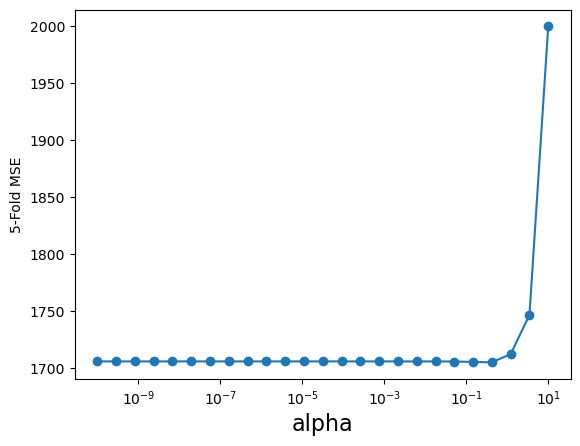

In [308]:
alpha_vector = np.logspace(-10,1,25)

param_grid = {'alpha': alpha_vector }
grid_lasso = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid_lasso.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
print("best parameters: {}".format(grid_lasso.best_params_))

scores = -1*np.array(grid_lasso.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [313]:
alpha_optimo = grid_lasso.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)
# predicción
y_predict_lasso = lasso.predict(X_test)
w = lasso.coef_
# error
error_test = np.mean(np.power(y_test - y_predict_lasso,2)) 
print(f'El error medio es de: {round(error_test,2)}')
print('---------------------------------------------')
for wi,col in zip(w, columns):
    print(col, wi)
mse_lasso = mean_squared_error(y_test, y_predict_lasso)
rmse_lasso = mean_absolute_error(y_test, y_predict_lasso)
print('\n --------------------------')
print(f'MSE Lasso ={mse_lasso}')
print(f'RMSE Lasso ={rmse_lasso}')

El error medio es de: 1420.93
---------------------------------------------
Neighbourhood_Group_Cleansed 6.646164718370879
Property_Type 0.0
Room_Type 14.119312105645845
Accommodates 10.809007932053007
Bathrooms 9.65703930996862
Bedrooms 13.376054577658659
Beds -0.0
Bed_Type 0.09954270607003166
Cancellation_Policy -0.0
A/C_NO -5.610169921564074
A/C_SI 0.0
Heat_NO 0.11391409081332814
Heat_SI -8.640458880609238e-17
Sec_Dep_NO 2.135474608146444
Sec_Dep_SI -0.0

 --------------------------
MSE Lasso =1420.9347385425217
RMSE Lasso =21.461596601139814


**Regularización Ridge**

best mean cross-validation score: -1705.448
best parameters: {'alpha': 138.9495494373136}


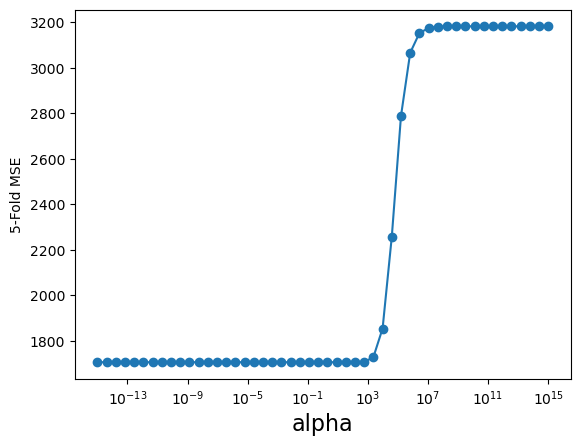

In [314]:
# df_numeric = df.dropna().select_dtypes(include=['float64', 'int64'])
alpha_vector = np.logspace(-15,15,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train,y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()


In [315]:
alpha_optimo = grid.best_params_['alpha']

ridge = Ridge(alpha = alpha_optimo).fit(X_train,y_train)
#ridge = grid.best_estimator_ -> otra forma de acceder al mejor estimador según GridSearch

# predicción
y_predict_ridge = ridge.predict(X_test)
w = ridge.coef_
# error
error_test = np.mean(np.power(y_test - y_predict_ridge,2)) 
print(f'El error medio es de: {round(error_test,2)}')
print('---------------------------------------------')
coef_names = ['w' + str(i) + ': ' for i in range(1,X_train.shape[1]+1)]

for wi,col in zip(w, columns):
    print(col, wi)
mse_ridge = mean_squared_error(y_test, y_predict_ridge)
rmse_ridge = mean_absolute_error(y_test, y_predict_ridge)
print('\n --------------------------')
print(f'MSE Ridge ={mse_ridge}')
print(f'RMSE Ridge ={rmse_ridge}')


El error medio es de: 1419.27
---------------------------------------------
Neighbourhood_Group_Cleansed 6.935959878160954
Property_Type 0.08868847092253297
Room_Type 14.247734435430228
Accommodates 11.721221679732224
Bathrooms 10.018699192404865
Bedrooms 13.648798487617647
Beds -1.104780945489013
Bed_Type 0.49144569057667836
Cancellation_Policy -0.3156004178225014
A/C_NO -3.0236255514532244
A/C_SI 3.0236255514531303
Heat_NO 0.30403243441512406
Heat_SI -0.30403243441548783
Sec_Dep_NO 1.3556772865318194
Sec_Dep_SI -1.3556772865317308

 --------------------------
MSE Ridge =1419.2717712083167
RMSE Ridge =21.59019326387072


**Random Forest**

Fitting 10 folds for each of 14 candidates, totalling 140 fits
best mean cross-validation score: 0.111
best parameters: {'max_depth': 10}


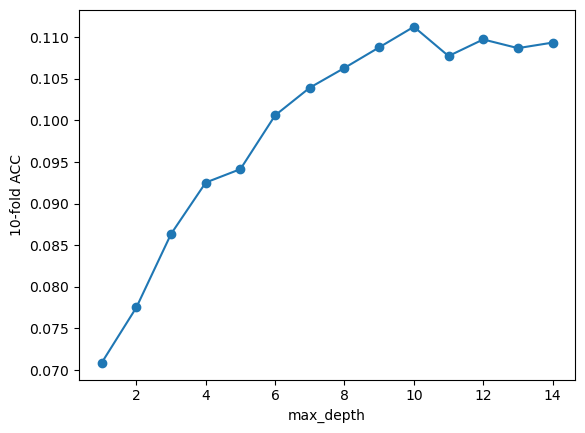

In [339]:
# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10, verbose=1) 
grid_rf.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_rf.best_score_))
print("best parameters: {}".format(grid_rf.best_params_))

scores = np.array(grid_rf.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [334]:
maxDepthOptimo = grid_rf.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

    
print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.3542656279688391
Test:  0.12028930338789494


In [340]:
modelo_final = grid_rf.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_rf}")

El error (rmse) de test es: 40.61026196018768


**BoostingRegressor**

In [335]:
Niterations = [500,1000,1500,2000]
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid_br = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5, verbose=2)
grid_br.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_br.best_score_))
print("best parameters: {}".format(grid_br.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.9s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   3.1s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.9s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.8s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   3.2s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   6.2s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   6.1s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   6.2s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   6.0s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=   6.2s
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=   9.4s
[CV] END ...............learning_rate=0.1, n_esti

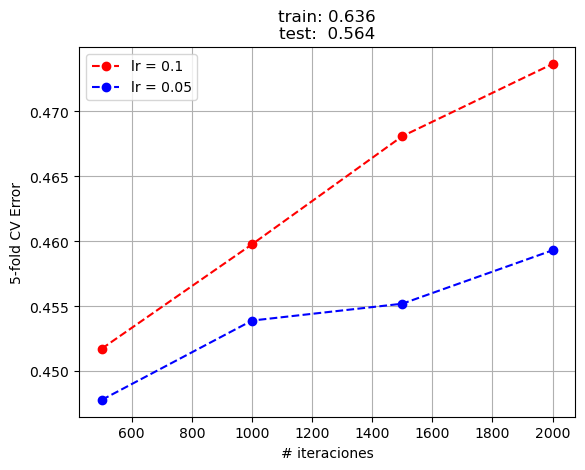

In [336]:
lrOptimo = grid_br.best_params_['learning_rate']
neOptimo = grid_br.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid_br.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

In [342]:
modelo_final_boosting = grid.best_estimator_
predicciones = modelo_final_boosting.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_gbm}")

El error (rmse) de test es: 35.754365542000045


# Conclusiones

**Vamos a comparar el error de los 5 modelos comparados**

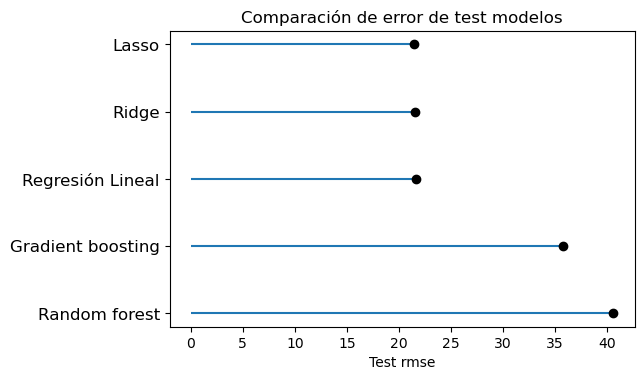

In [344]:
error_modelos = pd.DataFrame({
                        'modelo': ['Regresión Lineal', 'Lasso', 'Ridge','Random forest', 'Gradient boosting'],
                        'rmse': [rmse_lr, rmse_lasso, rmse_ridge, rmse_rf, rmse_gbm]
                     })
error_modelos = error_modelos.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.rmse)
ax.plot(error_modelos.rmse, error_modelos.modelo, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test modelos'),
ax.set_xlabel('Test rmse');

Tras entrenar varios modelos, comprobamos que ninguno de ellos es capaz de realizar una predicción con una alta precisión del precio de los alojamientos. En este caso los modelos que mejor resultado dan es la regresión lineal y las regularizaciones de Lasso y Ridge. Con random forest obtenemos una precisión muy baja en train 35% y en test aun mas baja de 11% y un Rmse muy elevado